<a href="https://colab.research.google.com/github/ericyoc/safe_unsafe_traffic_signs_poc/blob/main/safe_unsafe_traffic_signs_dataset_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install torch torchvision opencv-python wget matplotlib pillow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from datetime import datetime

# ===========================
# GLOBAL CONFIGURATION
# ===========================

NUM_REPLICAS = 3000  # Number of replica variations to generate
SAFE_UNSAFE_RATIO = 0.5  # 50% safe, 50% unsafe

# MUTCD Safety Thresholds for YIELD signs (White on Red)
MUTCD_LEGEND_MIN = 35.0    # White legend minimum
MUTCD_BACKGROUND_MIN = 7.0  # Red background minimum
MUTCD_CONTRAST_MIN = 3.0   # Contrast ratio minimum

# Expanded ranges to enable both safe and unsafe generation
LEGEND_RA_RANGE = (25.0, 120.0)      # Below and above MUTCD minimum (35)
BACKGROUND_RA_RANGE = (4.0, 600.0)  # Below and above MUTCD minimum (7)
CONTRAST_RANGE = (0.05, 6.0)         # Below and above MUTCD minimum (3.0)

GAN_EPOCHS = 3000  # Number of training epochs for GAN
OUTPUT_DIR = "/content/yield_replicas_balanced"  # Output directory for generated images

def determine_sign_safety_yield(legend_ra, background_ra, contrast_val):
    """
    Determine if YIELD sign meets MUTCD safety standards
    Returns 'SAFE' or 'UNSAFE'
    """
    if (legend_ra >= MUTCD_LEGEND_MIN and
        background_ra >= MUTCD_BACKGROUND_MIN and
        contrast_val >= MUTCD_CONTRAST_MIN):
        return "SAFE"
    else:
        return "UNSAFE"

def generate_balanced_parameters(num_replicas, safe_ratio=0.5):
    """
    Generate balanced safe/unsafe parameter combinations
    """
    num_safe = int(num_replicas * safe_ratio)
    num_unsafe = num_replicas - num_safe

    parameters = []

    print(f"Generating {num_safe} SAFE and {num_unsafe} UNSAFE parameter combinations...")

    # Generate SAFE combinations
    safe_count = 0
    attempts = 0
    max_attempts = num_safe * 10

    while safe_count < num_safe and attempts < max_attempts:
        # Ensure ALL parameters meet MUTCD minimums with safety margin
        legend_ra = np.random.uniform(80.0, LEGEND_RA_RANGE[1])       # 80-120 '(very bright white)
        background_ra = np.random.uniform(300.0, BACKGROUND_RA_RANGE[1])  # 300-600 (very bright red)
        contrast_val = np.random.uniform(4.5, CONTRAST_RANGE[1])          # 4.5-6.0 (high contrast)

        safety_status = determine_sign_safety_yield(legend_ra, background_ra, contrast_val)

        if safety_status == "SAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': 'SAFE_TARGET'
            })
            safe_count += 1

        attempts += 1

    # Generate UNSAFE combinations
    unsafe_strategies = [
        'legend_fail',     # Legend below minimum
        'background_fail', # Background below minimum
        'contrast_fail',   # Contrast below minimum
        'multiple_fail'    # Multiple parameters fail
    ]

    unsafe_count = 0
    attempts = 0
    max_attempts = num_unsafe * 10

    while unsafe_count < num_unsafe and attempts < max_attempts:
        strategy = np.random.choice(unsafe_strategies)

        if strategy == 'legend_fail':
            # Legend fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], 45.0)       # 25-45 (dark/dim white)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'background_fail':
            # Background fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 20.0)    # 4-20 (very dark red)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'contrast_fail':
            # Contrast fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.05-1.5 (low contrast)

        else:  # multiple_fail
            # Multiple parameters fail
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], 45.0)       # 25-45 (dark/dim white)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 20.0)    # 4-20 (very dark red)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.05-1.5 (low contrast)

        safety_status = determine_sign_safety_yield(legend_ra, background_ra, contrast_val)

        if safety_status == "UNSAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': f'UNSAFE_{strategy.upper()}'
            })
            unsafe_count += 1

        attempts += 1

    # Fill any remaining slots if we couldn't generate enough
    while len(parameters) < num_replicas:
        legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
        background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
        contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])
        safety_status = determine_sign_safety_yield(legend_ra, background_ra, contrast_val)

        parameters.append({
            'legend_ra': legend_ra,
            'background_ra': background_ra,
            'contrast': contrast_val,
            'safety_status': safety_status,
            'variation_type': f'{safety_status}_RANDOM'
        })

    # Shuffle to randomize order
    np.random.shuffle(parameters)

    # Verify final balance
    final_safe_count = sum(1 for p in parameters if p['safety_status'] == 'SAFE')
    final_unsafe_count = sum(1 for p in parameters if p['safety_status'] == 'UNSAFE')

    print(f"Parameter generation complete:")
    print(f"   SAFE: {final_safe_count} ({final_safe_count/len(parameters)*100:.1f}%)")
    print(f"   UNSAFE: {final_unsafe_count} ({final_unsafe_count/len(parameters)*100:.1f}%)")

    return parameters

def compute_reflectivity_and_contrast(image_tensor):
    image = (image_tensor.clone().detach().cpu() + 1) / 2
    image_gray = image.mean(dim=1, keepdim=True)
    values = image_gray.view(-1)
    reflectivity = values.mean().item()
    contrast = values.std().item()
    return reflectivity, contrast

def determine_and_fill_yield_sign_regions(
    img_path="/content/yield_sign.jpg",
    outer_color=(0, 255, 0),     # Green for outer region
    inner_color=(255, 255, 0),   # Yellow for inner region
    letter_color=(255, 0, 255)   # Magenta for letters
):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[ERROR] Failed to load image: {img_path}")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_display = img_rgb.copy()
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, w = img_bgr.shape[:2]

    # === Outer Triangle Detection ===
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    outer_mask = cv2.bitwise_or(mask1, mask2)
    outer_mask = cv2.morphologyEx(outer_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    outer_mask = cv2.morphologyEx(outer_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    contours_outer, _ = cv2.findContours(outer_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    outer_contour = None
    for cnt in sorted(contours_outer, key=cv2.contourArea, reverse=True):
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3 and cv2.contourArea(cnt) > 0.1 * h * w:
            outer_contour = cnt
            break

    if outer_contour is None:
        print("[ERROR] Outer triangle not found.")
        return None

    cv2.drawContours(img_display, [outer_contour], -1, outer_color, -1)

    # === Inner Triangle Detection ===
    lower_inner = np.array([0, 0, 180])
    upper_inner = np.array([180, 50, 255])
    inner_mask = cv2.inRange(img_hsv, lower_inner, upper_inner)

    outer_mask_only = np.zeros_like(inner_mask)
    cv2.drawContours(outer_mask_only, [outer_contour], -1, 255, -1)
    inner_mask = cv2.bitwise_and(inner_mask, inner_mask, mask=outer_mask_only)
    inner_mask = cv2.morphologyEx(inner_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    inner_mask = cv2.morphologyEx(inner_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    contours_inner, _ = cv2.findContours(inner_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    inner_contour = None
    for cnt in sorted(contours_inner, key=cv2.contourArea, reverse=True):
        area = cv2.contourArea(cnt)
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3 and 50 < area < 0.7 * cv2.contourArea(outer_contour):
            inner_contour = cnt
            break

    if inner_contour is not None:
        cv2.drawContours(img_display, [inner_contour], -1, inner_color, -1)

        # === Letter Region Detection ===
        x, y, w_box, h_box = cv2.boundingRect(inner_contour)
        roi = img_bgr[y:y+h_box, x:x+w_box]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))
        contours_letters, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        if hierarchy is not None:
            for idx, cnt in enumerate(contours_letters):
                area = cv2.contourArea(cnt)
                if 10 < area < 0.1 * w_box * h_box and hierarchy[0][idx][3] == -1:
                    M = cv2.moments(cnt)
                    if M["m00"] != 0:
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                        global_cX, global_cY = cX + x, cY + y
                        if cv2.pointPolygonTest(inner_contour, (global_cX, global_cY), False) >= 0:
                            cnt_shifted = cnt + [x, y]
                            cv2.drawContours(img_display, [cnt_shifted], -1, letter_color, -1)

    return img_display

def create_replica_yield_sign(segmented_img, legend_ra, background_ra, contrast_val):
    """Create replica yield sign using 3 separate conditions"""
    replica = segmented_img.copy()

    legend_intensity = int(np.clip(legend_ra * 4, 0, 255))
    background_intensity = int(np.clip(background_ra * 0.4, 0, 255))
    contrast_factor = contrast_val * 10

    legend_target_color = (legend_intensity, 0, 0)
    background_target_color = (background_intensity, background_intensity, background_intensity)
    letter_target_color = (0, 0, int(legend_intensity * 0.8))

    green_mask = np.all(replica == [0, 255, 0], axis=2)
    replica[green_mask] = legend_target_color

    yellow_mask = np.all(replica == [255, 255, 0], axis=2)
    replica[yellow_mask] = background_target_color

    magenta_mask = np.all(replica == [255, 0, 255], axis=2)
    replica[magenta_mask] = letter_target_color

    replica_float = replica.astype(np.float32)
    replica_float = np.clip(replica_float * (1 + contrast_factor), 0, 255)
    replica = replica_float.astype(np.uint8)

    return replica

# === Updated Conditional GAN Implementation ===
class Generator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Generator, self).__init__()
        self.condition_dim = condition_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512 + 64, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x, condition):
        encoded = self.encoder(x)
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8)
        combined = torch.cat([encoded, cond_reshaped], dim=1)
        output = self.decoder(combined)
        return output

class Discriminator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Discriminator, self).__init__()
        self.condition_dim = condition_dim

        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512 + 64, 1, 8, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x, condition):
        img_features = self.image_conv(x)
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8)
        combined = torch.cat([img_features, cond_reshaped], dim=1)
        output = self.classifier(combined)
        return output.view(-1)

def train_conditional_gan(replica_tensor, target_tensor, legend_ra, background_ra, contrast_val, epochs=GAN_EPOCHS):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    l1_criterion = nn.L1Loss()

    condition = torch.tensor([
        legend_ra / 1000,
        background_ra / 1000,
        contrast_val * 10
    ], dtype=torch.float32).unsqueeze(0).to(device)

    print(f"Training 3-Condition GAN for {epochs} epochs...")

    for epoch in range(epochs):
        d_optimizer.zero_grad()

        real_labels = torch.ones(1).to(device)
        fake_labels = torch.zeros(1).to(device)

        real_output = discriminator(target_tensor, condition)
        real_loss = criterion(real_output, real_labels)

        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images.detach(), condition)
        fake_loss = criterion(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images, condition)

        adversarial_loss = criterion(fake_output, real_labels)
        l1_loss = l1_criterion(fake_images, target_tensor) * 100

        g_loss = adversarial_loss + l1_loss
        g_loss.backward()
        g_optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    print("3-Condition Training completed!")
    return generator

def generate_with_3_conditions(generator, replica_tensor, legend_ra, background_ra, contrast_val):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    condition = torch.tensor([
        legend_ra / 1000,
        background_ra / 1000,
        contrast_val * 10
    ], dtype=torch.float32).unsqueeze(0).to(device)

    generator.eval()
    with torch.no_grad():
        generated = generator(replica_tensor, condition)

    return generated

def save_image_and_metadata(image_np, filename, sign_type, legend_ra, background_ra, contrast_val,
                            actual_r, actual_c, metadata, replica_data, safety_status, variation_type):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    filepath = os.path.join(OUTPUT_DIR, filename)

    image_pil = Image.fromarray(image_np)
    image_pil.save(filepath)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    replica_data.append({
        'Filename': filename,
        'Sign_Type': sign_type,
        'MUTCD_Code': metadata['MUTCD Code'],
        'Legend_Ra': round(legend_ra, 1),
        'Background_Ra': round(background_ra, 1),
        'Target_Contrast': round(contrast_val, 4),
        'Actual_Reflectivity': round(actual_r, 4),
        'Actual_Contrast': round(actual_c, 4),
        'Safety_Status': safety_status,
        'Variation_Type': variation_type,
        'MUTCD_Compliant': 'YES' if safety_status == 'SAFE' else 'NO',
        'Delta_R': round(abs(actual_r - (legend_ra/1000 + background_ra/1000)/2), 4),
        'Delta_C': round(abs(actual_c - contrast_val), 4),
        'Latitude': metadata['Latitude'],
        'Longitude': metadata['Longitude'],
        'Age_Years': metadata['Age of Sign'],
        'Sheeting_Type': metadata['Sheeting Type'],
        'Generated_Time': timestamp
    })

    print(f"Saved: {filename} | {safety_status} | {variation_type}")

# --- Main script ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3)
])

image_file_path = "/content/yield_sign.jpg"
target_file_path = "/content/8.png"

replica_data = []
worldlist_path = os.path.join(OUTPUT_DIR, "worldlist.txt")
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    original_img_pil = Image.open(image_file_path).convert("RGB")
    target_img_pil = Image.open(target_file_path).convert("RGB")

    original_img = transform(original_img_pil).unsqueeze(0).to(device)
    target_img = transform(target_img_pil).unsqueeze(0).to(device)

except FileNotFoundError:
    print(f"Error: Make sure '{image_file_path}' and '{target_file_path}' are accessible.")
    original_img = torch.rand(1, 3, 128, 128).to(device) * 2 - 1
    target_img = torch.rand(1, 3, 128, 128).to(device) * 2 - 1

original_r, original_c = compute_reflectivity_and_contrast(original_img)
target_r, target_c = compute_reflectivity_and_contrast(target_img)

# Use middle values for initial training
legend_ra = (LEGEND_RA_RANGE[0] + LEGEND_RA_RANGE[1]) / 2
background_ra = (BACKGROUND_RA_RANGE[0] + BACKGROUND_RA_RANGE[1]) / 2
contrast = (CONTRAST_RANGE[0] + CONTRAST_RANGE[1]) / 2

metadata = {
    "Latitude": 33.5163605,
    "Longitude": -80.8658667,
    "Sats": 8,
    "Facing (°)": 36.3,
    "Tilt (°)": 30.0,
    "Rotation (°)": 83.375,
    "MUTCD Code": "R1-2-36",
    "Age of Sign": 6.1,
    "Sheeting Type": "TYPE III PRISM HIGH INTENSITY",
    "Comment": "Yield"
}

target_np_unnorm = (target_img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
target_np = target_np_unnorm.astype(np.uint8)

print(f"=== BALANCED YIELD SIGN DATASET CONFIGURATION ===")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Number of replicas: {NUM_REPLICAS}")
print(f"Safe/Unsafe ratio: {SAFE_UNSAFE_RATIO*100:.0f}% SAFE, {(1-SAFE_UNSAFE_RATIO)*100:.0f}% UNSAFE")
print(f"MUTCD Safety Thresholds:")
print(f"   Legend Ra minimum: {MUTCD_LEGEND_MIN}")
print(f"   Background Ra minimum: {MUTCD_BACKGROUND_MIN}")
print(f"   Contrast minimum: {MUTCD_CONTRAST_MIN}")
print(f"Generation Ranges:")
print(f"   Legend Ra: {LEGEND_RA_RANGE[0]} - {LEGEND_RA_RANGE[1]}")
print(f"   Background Ra: {BACKGROUND_RA_RANGE[0]} - {BACKGROUND_RA_RANGE[1]}")
print(f"   Contrast: {CONTRAST_RANGE[0]} - {CONTRAST_RANGE[1]}")

# Generate all processing steps
original_full = cv2.imread(image_file_path)
original_full_rgb = cv2.cvtColor(original_full, cv2.COLOR_BGR2RGB)

segmented_original = determine_and_fill_yield_sign_regions(image_file_path)
replica_yield_sign = create_replica_yield_sign(segmented_original, legend_ra, background_ra, contrast)

replica_pil = Image.fromarray(replica_yield_sign)
replica_tensor = transform(replica_pil).unsqueeze(0).to(device)

print("Starting 3-Condition GAN training...")
trained_generator = train_conditional_gan(replica_tensor, target_img, legend_ra, background_ra, contrast)

generated_replica_tensor = generate_with_3_conditions(trained_generator, replica_tensor, legend_ra, background_ra, contrast)
generated_replica_np = (generated_replica_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
generated_replica_np = generated_replica_np.astype(np.uint8)
generated_r, generated_c = compute_reflectivity_and_contrast(generated_replica_tensor)

# Generate balanced parameter combinations
balanced_parameters = generate_balanced_parameters(NUM_REPLICAS, SAFE_UNSAFE_RATIO)

print(f"Generating {NUM_REPLICAS} balanced variations...")
variation_results = []
for i, params in enumerate(balanced_parameters):
    var_legend = params['legend_ra']
    var_background = params['background_ra']
    var_contrast = params['contrast']
    safety_status = params['safety_status']
    variation_type = params['variation_type']

    var_tensor = generate_with_3_conditions(trained_generator, replica_tensor, var_legend, var_background, var_contrast)
    var_np = (var_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
    var_np = var_np.astype(np.uint8)

    actual_r, actual_c = compute_reflectivity_and_contrast(var_tensor)

    filename = f"yield_{i+1:03d}_{safety_status.lower()}.png"
    save_image_and_metadata(var_np, filename, "YIELD", var_legend, var_background, var_contrast,
                            actual_r, actual_c, metadata, replica_data, safety_status, variation_type)

    variation_results.append((var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type))

# ===========================
# COMPLETE LOGICAL PROGRESSION VISUALIZATIONS
# ===========================

# Calculate total rows (6 base steps + NUM_REPLICAS variations)
total_rows = 6 + NUM_REPLICAS
fig, axes = plt.subplots(total_rows, 2, figsize=(12, total_rows * 3))

# Step 1: Original Image → Target Reference
axes[0,0].imshow(original_full_rgb)
axes[0,0].set_title("Step 1: Original Yield Sign Image\n(Raw input from camera)", fontsize=10, pad=10)
axes[0,0].axis("off")

axes[0,1].imshow(target_np)
axes[0,1].set_title("Step 1: Target Reference Image\n(Desired output characteristics)", fontsize=10, pad=10)
axes[0,1].axis("off")

# Step 2: Region Segmentation
axes[1,0].imshow(segmented_original)
axes[1,0].set_title("Step 2: Region Segmentation\nGreen: Legend, Yellow: Background, Magenta: Letters", fontsize=10, pad=10)
axes[1,0].axis("off")

axes[1,1].imshow(target_np)
axes[1,1].set_title(f"Step 2: Target 3-Conditions\nLegend Ra: {legend_ra:.3f}, Background Ra: {background_ra:.3f}\nContrast: {contrast:.4f}", fontsize=10, pad=10)
axes[1,1].axis("off")

# Step 3: Initial Replica Creation
axes[2,0].imshow(replica_yield_sign)
axes[2,0].set_title("Step 3: Initial Replica\n(Basic color mapping using 3-condition values)", fontsize=10, pad=10)
axes[2,0].axis("off")

axes[2,1].imshow(target_np)
axes[2,1].set_title("Step 3: GAN Training Target\n(What we want the 3-condition GAN to learn)", fontsize=10, pad=10)
axes[2,1].axis("off")

# Step 4: GAN Training Result
axes[3,0].imshow(generated_replica_np)
title4_left = f"Step 4: 3-Condition GAN Result\nLegend Ra: {legend_ra:.3f}, Background Ra: {background_ra:.3f}, Contrast: {contrast:.4f}\nActual R: {generated_r:.4f}, C: {generated_c:.4f}\n(After {GAN_EPOCHS} epochs training)"
axes[3,0].set_title(title4_left, fontsize=9, pad=10)
axes[3,0].axis("off")

axes[3,1].imshow(target_np)
title4_right = f"Step 4: Target Validation\nLegend Ra: {legend_ra:.3f}, Background Ra: {background_ra:.3f}, Contrast: {contrast:.4f}\nTarget R: {target_r:.4f}, C: {target_c:.4f}\nΔR: {abs(target_r - generated_r):.4f}, ΔC: {abs(target_c - generated_c):.4f}"
axes[3,1].set_title(title4_right, fontsize=9, pad=10)
axes[3,1].axis("off")

# Step 5: Configuration Summary
axes[4,0].text(0.5, 0.5, f"Step 5: Balanced Variation Setup\n\n" +
               f"Total Replicas: {NUM_REPLICAS}\n" +
               f"SAFE: {int(NUM_REPLICAS*SAFE_UNSAFE_RATIO)} ({SAFE_UNSAFE_RATIO*100:.0f}%)\n" +
               f"UNSAFE: {int(NUM_REPLICAS*(1-SAFE_UNSAFE_RATIO))} ({(1-SAFE_UNSAFE_RATIO)*100:.0f}%)\n" +
               f"Legend Ra Range: {LEGEND_RA_RANGE[0]:.0f} - {LEGEND_RA_RANGE[1]:.0f}\n" +
               f"Background Ra Range: {BACKGROUND_RA_RANGE[0]:.0f} - {BACKGROUND_RA_RANGE[1]:.0f}\n" +
               f"Contrast Range: {CONTRAST_RANGE[0]:.2f} - {CONTRAST_RANGE[1]:.2f}\n\n" +
               f"Files saved to: {OUTPUT_DIR}",
               ha='center', va='center', fontsize=12, transform=axes[4,0].transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
axes[4,0].axis("off")

axes[4,1].imshow(target_np)
axes[4,1].set_title("Step 5: Base Target Reference\n(Used for all balanced variations)", fontsize=10, pad=10)
axes[4,1].axis("off")

# Step 6: Start of Variations
axes[5,0].text(0.5, 0.5, f"Step 6: Balanced SAFE/UNSAFE Variations\n\nGenerating {NUM_REPLICAS} replicas with\nbalanced safety distribution\nfor CNN training dataset",
               ha='center', va='center', fontsize=12, transform=axes[5,0].transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
axes[5,0].axis("off")

axes[5,1].imshow(target_np)
axes[5,1].set_title("Step 6: Reference Standard\n(Consistent comparison baseline)", fontsize=10, pad=10)
axes[5,1].axis("off")

# Steps 7+: Individual Variations
for i, (var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type) in enumerate(variation_results):
    row_idx = i + 6

    # Left: Generated Variation
    axes[row_idx,0].imshow(var_np)
    title_var = f"Variation {i+1}: {safety_status}\nLegend Ra: {var_legend:.1f}, Background Ra: {var_background:.1f}\nContrast: {var_contrast:.3f} | R: {actual_r:.4f}, C: {actual_c:.4f}\nType: {variation_type}"

    # Color code title based on safety status
    title_color = 'green' if safety_status == 'SAFE' else 'red'
    axes[row_idx,0].set_title(title_var, fontsize=9, pad=10, color=title_color)
    axes[row_idx,0].axis("off")

    # Right: Target Reference (consistent)
    axes[row_idx,1].imshow(target_np)
    axes[row_idx,1].set_title(f"Target Reference\nLegend Ra: {legend_ra:.3f}, Background Ra: {background_ra:.3f}\nContrast: {contrast:.4f} | R: {target_r:.4f}, C: {target_c:.4f}", fontsize=9, pad=10)
    axes[row_idx,1].axis("off")

plt.tight_layout()
plt.show()

# ===========================
# CREATE COMPREHENSIVE TABLE
# ===========================

df = pd.DataFrame(replica_data)

csv_path = os.path.join(OUTPUT_DIR, "balanced_replica_dataset.csv")
df.to_csv(csv_path, index=False)

with open(worldlist_path, 'w') as f:
    f.write("filename|sign_type|mutcd_code|legend_ra|background_ra|target_contrast|actual_r|actual_c|safety_status|mutcd_compliant|variation_type|latitude|longitude|age_years|sheeting_type|timestamp\n")
    for _, row in df.iterrows():
        f.write(f"{row['Filename']}|{row['Sign_Type']}|{row['MUTCD_Code']}|{row['Legend_Ra']}|{row['Background_Ra']}|{row['Target_Contrast']}|{row['Actual_Reflectivity']}|{row['Actual_Contrast']}|{row['Safety_Status']}|{row['MUTCD_Compliant']}|{row['Variation_Type']}|{row['Latitude']}|{row['Longitude']}|{row['Age_Years']}|{row['Sheeting_Type']}|{row['Generated_Time']}\n")

print("\n" + "="*120)
print("BALANCED YIELD SIGN REPLICA DATASET - COMPREHENSIVE TABLE")
print("="*120)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

print(df.to_string(index=False))

print("\n" + "="*80)
print("BALANCED DATASET SUMMARY STATISTICS")
print("="*80)

print(f"Total Images Generated: {len(df)}")
print(f"Sign Type: {df['Sign_Type'].iloc[0]}")
print(f"MUTCD Code: {df['MUTCD_Code'].iloc[0]}")
print(f"Output Directory: {OUTPUT_DIR}")

print(f"\nSafety Distribution:")
safe_count = len(df[df['Safety_Status'] == 'SAFE'])
unsafe_count = len(df[df['Safety_Status'] == 'UNSAFE'])
print(f"   SAFE: {safe_count} ({safe_count/len(df)*100:.1f}%)")
print(f"   UNSAFE: {unsafe_count} ({unsafe_count/len(df)*100:.1f}%)")

print(f"\nMUTCD Compliance:")
compliant_count = len(df[df['MUTCD_Compliant'] == 'YES'])
non_compliant_count = len(df[df['MUTCD_Compliant'] == 'NO'])
print(f"   COMPLIANT: {compliant_count} ({compliant_count/len(df)*100:.1f}%)")
print(f"   NON-COMPLIANT: {non_compliant_count} ({non_compliant_count/len(df)*100:.1f}%)")

print(f"\nVariation Type Distribution:")
for var_type in df['Variation_Type'].unique():
    count = len(df[df['Variation_Type'] == var_type])
    print(f"   {var_type}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nParameter Statistics:")
print(f"Legend Ra - Range: {df['Legend_Ra'].min():.1f} to {df['Legend_Ra'].max():.1f}, Mean: {df['Legend_Ra'].mean():.1f}")
print(f"Background Ra - Range: {df['Background_Ra'].min():.1f} to {df['Background_Ra'].max():.1f}, Mean: {df['Background_Ra'].mean():.1f}")
print(f"Contrast - Range: {df['Target_Contrast'].min():.3f} to {df['Target_Contrast'].max():.3f}, Mean: {df['Target_Contrast'].mean():.3f}")

print(f"\nSAFE vs UNSAFE Breakdown:")
print("SAFE Signs:")
safe_df = df[df['Safety_Status'] == 'SAFE']
if len(safe_df) > 0:
    print(f"   Legend Ra: {safe_df['Legend_Ra'].min():.1f} - {safe_df['Legend_Ra'].max():.1f}")
    print(f"   Background Ra: {safe_df['Background_Ra'].min():.1f} - {safe_df['Background_Ra'].max():.1f}")
    print(f"   Contrast: {safe_df['Target_Contrast'].min():.3f} - {safe_df['Target_Contrast'].max():.3f}")

print("UNSAFE Signs:")
unsafe_df = df[df['Safety_Status'] == 'UNSAFE']
if len(unsafe_df) > 0:
    print(f"   Legend Ra: {unsafe_df['Legend_Ra'].min():.1f} - {unsafe_df['Legend_Ra'].max():.1f}")
    print(f"   Background Ra: {unsafe_df['Background_Ra'].min():.1f} - {unsafe_df['Background_Ra'].max():.1f}")
    print(f"   Contrast: {unsafe_df['Target_Contrast'].min():.3f} - {unsafe_df['Target_Contrast'].max():.3f}")

print(f"\nFiles Saved:")
print(f"   Images: {OUTPUT_DIR}/*.png")


=== BALANCED YIELD SIGN DATASET CONFIGURATION ===
Output directory: /content/yield_replicas_balanced
Number of replicas: 3000
Safe/Unsafe ratio: 50% SAFE, 50% UNSAFE
MUTCD Safety Thresholds:
   Legend Ra minimum: 35.0
   Background Ra minimum: 7.0
   Contrast minimum: 3.0
Generation Ranges:
   Legend Ra: 25.0 - 120.0
   Background Ra: 4.0 - 600.0
   Contrast: 0.05 - 6.0
Starting 3-Condition GAN training...
Training 3-Condition GAN for 3000 epochs...
Epoch [0/3000] D_loss: 0.9515 G_loss: 108.7012
Epoch [100/3000] D_loss: 0.8570 G_loss: 11.8924
Epoch [200/3000] D_loss: 0.8823 G_loss: 7.5049
Epoch [300/3000] D_loss: 0.6830 G_loss: 8.6913
Epoch [400/3000] D_loss: 0.0072 G_loss: 9.5286
Epoch [500/3000] D_loss: 0.0267 G_loss: 5.4287
Epoch [600/3000] D_loss: 0.0433 G_loss: 6.7861
Epoch [700/3000] D_loss: 0.7149 G_loss: 8.5877
Epoch [800/3000] D_loss: 2.4366 G_loss: 11.2720
Epoch [900/3000] D_loss: 2.3324 G_loss: 9.5829
Epoch [1000/3000] D_loss: 0.0028 G_loss: 11.5756
Epoch [1100/3000] D_loss:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from datetime import datetime

# ===========================
# GLOBAL CONFIGURATION
# ===========================

NUM_REPLICAS = 3000  # Number of replica variations to generate
SAFE_UNSAFE_RATIO = 0.5  # 50% safe, 50% unsafe

# MUTCD Safety Thresholds for STOP signs (White on Red)
MUTCD_LEGEND_MIN = 35.0    # White legend minimum
MUTCD_BACKGROUND_MIN = 7.0  # Red background minimum
MUTCD_CONTRAST_MIN = 3.0   # Contrast ratio minimum

# Expanded ranges to enable both safe and unsafe generation
LEGEND_RA_RANGE = (25.0, 750.0)      # Below and above MUTCD minimum (35)
BACKGROUND_RA_RANGE = (4.0, 400.0)    # Below and above MUTCD minimum (7)
CONTRAST_RANGE = (1.0, 20.0)          # Below and above MUTCD minimum (3.0)

GAN_EPOCHS = 3000  # Number of training epochs for GAN
OUTPUT_DIR = "/content/stop_replicas_balanced" # Output directory for generated images

def determine_sign_safety_stop(legend_ra, background_ra, contrast_val):
    """
    Determine if STOP sign meets MUTCD safety standards
    Returns 'SAFE' or 'UNSAFE'
    """
    if (legend_ra >= MUTCD_LEGEND_MIN and
        background_ra >= MUTCD_BACKGROUND_MIN and
        contrast_val >= MUTCD_CONTRAST_MIN):
        return "SAFE"
    else:
        return "UNSAFE"

def generate_balanced_parameters(num_replicas, safe_ratio=0.5):
    """
    Generate balanced safe/unsafe parameter combinations
    """
    num_safe = int(num_replicas * safe_ratio)
    num_unsafe = num_replicas - num_safe

    parameters = []

    print(f"Generating {num_safe} SAFE and {num_unsafe} UNSAFE parameter combinations...")

    # Generate SAFE combinations
    safe_count = 0
    attempts = 0
    max_attempts = num_safe * 10

    while safe_count < num_safe and attempts < max_attempts:
        # Ensure ALL parameters meet MUTCD minimums with safety margin
        legend_ra = np.random.uniform(400.0, LEGEND_RA_RANGE[1])       # 400-750 (very bright white)
        background_ra = np.random.uniform(200.0, BACKGROUND_RA_RANGE[1])  # 200-400 (very bright red)
        contrast_val = np.random.uniform(12.0, CONTRAST_RANGE[1])          # 12.0-20.0 (high contrast)

        safety_status = determine_sign_safety_stop(legend_ra, background_ra, contrast_val)

        if safety_status == "SAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': 'SAFE_TARGET'
            })
            safe_count += 1

        attempts += 1

    # Generate UNSAFE combinations
    unsafe_strategies = [
        'legend_fail',     # Legend below minimum
        'background_fail', # Background below minimum
        'contrast_fail',   # Contrast below minimum
        'multiple_fail'    # Multiple parameters fail
    ]

    unsafe_count = 0
    attempts = 0
    max_attempts = num_unsafe * 10

    while unsafe_count < num_unsafe and attempts < max_attempts:
        strategy = np.random.choice(unsafe_strategies)

        if strategy == 'legend_fail':
            # Legend fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], 60.0)        # 25-60 (dark/dim white)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'background_fail':
            # Background fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 20.0)    # 4-20 (very dark red)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'contrast_fail':
            # Contrast fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.05-1.5 (low contrast)

        else:  # multiple_fail
            # Multiple parameters fail
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], 60.0)        # 25-60 (dark/dim white)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 20.0)    # 4-20 (very dark red)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.05-1.5 (low contrast)

        safety_status = determine_sign_safety_stop(legend_ra, background_ra, contrast_val)

        if safety_status == "UNSAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': f'UNSAFE_{strategy.upper()}'
            })
            unsafe_count += 1

        attempts += 1

    # Fill any remaining slots if we couldn't generate enough
    while len(parameters) < num_replicas:
        legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
        background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
        contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])
        safety_status = determine_sign_safety_stop(legend_ra, background_ra, contrast_val)

        parameters.append({
            'legend_ra': legend_ra,
            'background_ra': background_ra,
            'contrast': contrast_val,
            'safety_status': safety_status,
            'variation_type': f'{safety_status}_RANDOM'
        })

    # Shuffle to randomize order
    np.random.shuffle(parameters)

    # Verify final balance
    final_safe_count = sum(1 for p in parameters if p['safety_status'] == 'SAFE')
    final_unsafe_count = sum(1 for p in parameters if p['safety_status'] == 'UNSAFE')

    print(f"Parameter generation complete:")
    print(f"   SAFE: {final_safe_count} ({final_safe_count/len(parameters)*100:.1f}%)")
    print(f"   UNSAFE: {final_unsafe_count} ({final_unsafe_count/len(parameters)*100:.1f}%)")

    return parameters

# --- Utility Functions ---
def compute_reflectivity_and_contrast(image_tensor):
    """Computes a simplified 'reflectivity' (mean intensity) and 'contrast' (std dev)
    for a given image tensor, scaled back to 0-1 range."""
    # Denormalize image from [-1, 1] to [0, 1]
    image = (image_tensor.clone().detach().cpu() + 1) / 2
    # Convert to grayscale for overall intensity
    image_gray = image.mean(dim=1, keepdim=True)
    values = image_gray.view(-1)
    # Simple mean as reflectivity, std as contrast. This is a simplification
    # compared to actual retroreflectivity and contrast ratio calculations.
    reflectivity = values.mean().item()
    contrast = values.std().item()
    return reflectivity, contrast

def determine_and_fill_stop_sign_regions(
    img_path="/content/stopsign.jpg",   # Original stop sign image
    outer_color=(0, 255, 0),     # Green for outer region (red background)
    inner_color=(255, 255, 0),   # Yellow for inner region (white text area) - generally the whole 'STOP' area
    letter_color=(255, 0, 255)   # Magenta for letters (STOP text) - for actual letter shape
):
    """
    Detects and fills regions of a STOP sign image based on color for segmentation.
    It identifies the red octagon, then the white text, and then the letters.
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[ERROR] Failed to load image: {img_path}")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_display = img_rgb.copy() # This will be the segmented image with color codes
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, w = img_bgr.shape[:2]

    # === Outer Octagon Detection (Red Background) ===
    # HSV ranges for red (wraps around 0/180)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    outer_mask = cv2.bitwise_or(mask1, mask2)

    # Morphological operations to clean up mask
    outer_mask = cv2.morphologyEx(outer_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    outer_mask = cv2.morphologyEx(outer_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    contours_outer, _ = cv2.findContours(outer_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    outer_contour = None
    # Sort contours by area to get the largest red region
    for cnt in sorted(contours_outer, key=cv2.contourArea, reverse=True):
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        # Look for octagon (8 sides), being flexible (6-10 sides) and a significant area
        if len(approx) >= 6 and len(approx) <= 10 and cv2.contourArea(cnt) > 0.1 * h * w:
            outer_contour = cnt
            break

    if outer_contour is None:
        print("[ERROR] Outer octagon (red background) not found.")
        return None

    # Fill the outer octagon with `outer_color` (green)
    cv2.drawContours(img_display, [outer_contour], -1, outer_color, -1)

    # === Inner Text Region Detection (White letters/area) ===
    # HSV range for white color
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 30, 255]) # Low saturation, high value
    inner_mask = cv2.inRange(img_hsv, lower_white, upper_white)

    # Apply the outer mask to the inner mask to only consider white areas within the stop sign
    outer_mask_only = np.zeros_like(inner_mask)
    cv2.drawContours(outer_mask_only, [outer_contour], -1, 255, -1)
    inner_mask = cv2.bitwise_and(inner_mask, inner_mask, mask=outer_mask_only)

    # Morphological operations for inner mask
    inner_mask = cv2.morphologyEx(inner_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    inner_mask = cv2.morphologyEx(inner_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    contours_inner, _ = cv2.findContours(inner_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill any significant white contours with `inner_color` (yellow)
    if contours_inner:
        for cnt in sorted(contours_inner, key=cv2.contourArea, reverse=True):
            area = cv2.contourArea(cnt)
            if area > 50: # Adjust threshold based on image resolution
                cv2.drawContours(img_display, [cnt], -1, inner_color, -1)

    # === Letter Region Detection (STOP text - refining the 'white' area to just the letters) ===
    # Extract ROI for faster processing (bounding box of the outer contour)
    x, y, w_box, h_box = cv2.boundingRect(outer_contour)
    roi = img_bgr[y:y+h_box, x:x+w_box]
    # Convert ROI to grayscale and apply adaptive thresholding for text extraction
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # Using adaptive thresholding can be more robust than a fixed value for text
    # _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY) # Original fixed threshold
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2) # Inverse for white text on dark background

    # Morphological operations to clean text contours
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

    # Find contours in the binary image, `RETR_CCOMP` helps with holes in letters (e.g., 'O', 'P')
    contours_letters, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if hierarchy is not None:
        hierarchy = hierarchy[0]
        for idx, cnt in enumerate(contours_letters):
            area = cv2.contourArea(cnt)
            # Filter contours that are likely letters (reasonable size, not holes)
            # `hierarchy[idx][3] == -1` means it's an outer contour (not a hole)
            if 50 < area < 0.3 * w_box * h_box and hierarchy[idx][3] == -1:
                # Calculate centroid to check if contour is within the stop sign outer boundary
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    global_cX, global_cY = cX + x, cY + y # Convert to global coordinates
                    if cv2.pointPolygonTest(outer_contour, (global_cX, global_cY), False) >= 0:
                        # Shift contour coordinates back to global image frame before drawing
                        cnt_shifted = cnt + [x, y]
                        cv2.drawContours(img_display, [cnt_shifted], -1, letter_color, -1)
    return img_display

def create_replica_stop_sign(segmented_img, legend_ra, background_ra, contrast_val):
    """
    Creates a replica of a STOP sign using the segmented image and
    desired reflectivity/contrast values.
    Args:
        segmented_img (np.array): Image with regions color-coded by `determine_and_fill_stop_sign_regions`.
        legend_ra (float): Target Retroreflectivity for the white legend (text).
        background_ra (float): Target Retroreflectivity for the red background.
        contrast_val (float): Target Contrast ratio (Legend Ra / Background Ra).
    Returns:
        np.array: The generated replica image.
    """
    replica = segmented_img.copy()

    # Mapping retroreflectivity to intensity (0-255). These are approximate
    # scaling factors and may need fine-tuning for visual realism.
    # The actual 'brightness' of a color is complex, but for a simple model,
    # we can scale a primary channel or all channels.

    # Red Background: Scale background_ra to a red color intensity
    # Red channel will be primary, green/blue set to low values for a red hue.
    background_red_intensity = int(np.clip(background_ra * 2, 0, 255)) # Scale up Ra for pixel intensity
    background_target_color = (background_red_intensity, 0, 0) # Red color (R, G, B)

    # White Legend (text itself): Scale legend_ra to white color intensity
    legend_white_intensity = int(np.clip(legend_ra * 0.3, 0, 255)) # Scale down Ra for pixel intensity
    legend_target_color = (legend_white_intensity, legend_white_intensity, legend_white_intensity) # White color

    # Apply colors to the segmented regions
    # Green (0,255,0) in segmented_img represents the Red Background area
    green_mask = np.all(replica == [0, 255, 0], axis=2)
    replica[green_mask] = background_target_color

    # Yellow (255,255,0) in segmented_img represents the general White text area (if distinct from letters)
    # For STOP signs, often the entire inner area *is* the lettering or a white border around it.
    # We will primarily use `letter_color` (magenta) for the actual "STOP" text.
    # So, the yellow region might be less relevant for the final "STOP" text.
    # If there's a white border around the letters, this would be its color.
    yellow_mask = np.all(replica == [255, 255, 0], axis=2)
    replica[yellow_mask] = legend_target_color # This targets the white *area*

    # Magenta (255,0,255) in segmented_img represents the actual "STOP" letters
    magenta_mask = np.all(replica == [255, 0, 255], axis=2)
    replica[magenta_mask] = legend_target_color # This targets the white *letters* using the legend_ra

    # Apply contrast - this is a simple multiplicative factor.
    # For a contrast ratio (L_Ra / B_Ra), we adjust intensities to achieve this.
    # A simple approach is to adjust the overall brightness, or specifically
    # enhance the difference between foreground and background.
    # Here, we're using a simple multiplier based on the given contrast value.
    # The `contrast_val` is a ratio (e.g., 3.0 to 15.0), so we scale it for pixel adjustment.
    # We'll adjust the overall image brightness based on the contrast value.
    # Convert to float for calculations
    replica_float = replica.astype(np.float32)

    # A simple approach for contrast is to scale the brightness.
    # The GAN will learn the nuanced contrast, but this gives it a good starting point.
    # Normalize contrast_val to a factor (e.g., around 1 for base contrast, higher for more contrast)
    # For a ratio from 3-15, a scaling like (contrast_val / 3.0) might work.
    contrast_factor_applied = contrast_val / (CONTRAST_RANGE[0] + CONTRAST_RANGE[1]) / 2 # Normalize to around 1
    contrast_factor_applied = 1.0 + (contrast_factor_applied - 0.5) * 0.5 # Adjust to be a factor like 0.75-1.25

    # Apply to all channels to influence overall brightness/contrast
    # This might be too simplistic and impact hues. The GAN is expected to fix this.
    replica_float = replica_float * contrast_factor_applied
    replica_float = np.clip(replica_float, 0, 255)
    replica = replica_float.astype(np.uint8)

    return replica

# --- GAN Classes ---
class Generator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Generator, self).__init__()
        self.condition_dim = condition_dim

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), # Input: 128x128 -> 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), # 64x64 -> 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), # 32x32 -> 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), # 16x16 -> 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Conditional Embedding for condition vector
        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64) # Reshape to match latent space spatial dimensions
        )

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512 + 64, 256, 4, 2, 1), # (512+64)@8x8 -> 256@16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 256@16x16 -> 128@32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 128@32x32 -> 64@64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), # 64@64x64 -> 3@128x128
            nn.Tanh() # Output image pixels in [-1, 1] range
        )

    def forward(self, x, condition):
        encoded = self.encoder(x)
        # Embed and reshape condition vector
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8) # Batch, Channels, H, W
        # Concatenate encoded image features with conditioned latent vector
        combined = torch.cat([encoded, cond_reshaped], dim=1)
        output = self.decoder(combined)
        return output

class Discriminator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Discriminator, self).__init__()
        self.condition_dim = condition_dim

        # Image Feature Extractor (Downsampling)
        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), # Input: 128x128 -> 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), # 64x64 -> 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), # 32x32 -> 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), # 16x16 -> 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Conditional Embedding for condition vector
        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64) # Reshape to match latent space spatial dimensions
        )

        # Classifier Head (determines real/fake)
        self.classifier = nn.Sequential(
            nn.Conv2d(512 + 64, 1, 8, 1, 0), # (512+64)@8x8 -> 1@1x1
            nn.Sigmoid() # Output a probability between 0 and 1
        )

    def forward(self, x, condition):
        img_features = self.image_conv(x)
        # Embed and reshape condition vector
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8) # Batch, Channels, H, W
        # Concatenate image features with conditioned latent vector
        combined = torch.cat([img_features, cond_reshaped], dim=1)
        output = self.classifier(combined)
        return output.view(-1) # Flatten to a single probability

def train_conditional_gan(replica_tensor, target_tensor, legend_ra, background_ra, contrast_val, epochs=GAN_EPOCHS):
    """
    Trains a Conditional GAN to transform an initial replica image into a target
    image based on specified retroreflectivity and contrast conditions.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss() # Binary Cross-Entropy for GAN adversarial loss
    l1_criterion = nn.L1Loss() # L1 Loss for pixel-wise similarity (to make generated look like real)

    # Prepare the condition vector for the GAN
    # Normalize the Ra values by dividing by a representative maximum (e.g., 1000 or the max of your range)
    # Normalize contrast by a representative max (e.g., 20 or the max of your range)
    condition = torch.tensor([
        legend_ra / 1000.0,    # Normalize Legend Ra (e.g., max Ra for white could be ~1000)
        background_ra / 400.0, # Normalize Background Ra (e.g., max Ra for red could be ~400)
        contrast_val / 20.0    # Normalize Contrast (e.g., max contrast could be ~20)
    ], dtype=torch.float32).unsqueeze(0).to(device) # unsqueeze(0) for batch dimension

    print(f"Training 3-Condition GAN for {epochs} epochs...")

    for epoch in range(epochs):
        # --- Train Discriminator ---
        d_optimizer.zero_grad()

        real_labels = torch.ones(1).to(device) # Label for real images
        fake_labels = torch.zeros(1).to(device) # Label for fake images

        # Real images
        real_output = discriminator(target_tensor, condition)
        real_loss = criterion(real_output, real_labels)

        # Fake images generated by Generator
        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images.detach(), condition) # detach to prevent G from updating
        fake_loss = criterion(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2 # Average discriminator loss
        d_loss.backward()
        d_optimizer.step()

        # --- Train Generator ---
        g_optimizer.zero_grad()

        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images, condition) # D's opinion of G's latest output

        adversarial_loss = criterion(fake_output, real_labels) # G wants D to think fakes are real
        l1_loss = l1_criterion(fake_images, target_tensor) * 100 # Pixel-wise similarity to target

        g_loss = adversarial_loss + l1_loss # Total generator loss
        g_loss.backward()
        g_optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    print("3-Condition Training completed!")
    return generator

def generate_with_3_conditions(generator, replica_tensor, legend_ra, background_ra, contrast_val):
    """
    Generates an image using the trained generator and specified conditions.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Prepare the condition vector, normalized the same way as during training
    condition = torch.tensor([
        legend_ra / 1000.0,
        background_ra / 400.0,
        contrast_val / 20.0
    ], dtype=torch.float32).unsqueeze(0).to(device)

    generator.eval() # Set generator to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        generated = generator(replica_tensor, condition)

    return generated

def save_image_and_metadata(image_np, filename, sign_type, legend_ra, background_ra, contrast_val,
                            actual_r, actual_c, metadata, replica_data, safety_status, variation_type):
    """Saves the generated image and appends its metadata to a list."""
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    filepath = os.path.join(OUTPUT_DIR, filename)

    image_pil = Image.fromarray(image_np)
    image_pil.save(filepath)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    replica_data.append({
        'Filename': filename,
        'Sign_Type': sign_type,
        'MUTCD_Code': metadata.get('MUTCD Code', 'N/A'), # Use .get() for safety
        'Legend_Ra': round(legend_ra, 3), # Store target value
        'Background_Ra': round(background_ra, 3), # Store target value
        'Target_Contrast': round(contrast_val, 4), # Store target value
        'Actual_Reflectivity': round(actual_r, 4), # From compute_reflectivity_and_contrast
        'Actual_Contrast': round(actual_c, 4),     # From compute_reflectivity_and_contrast
        'Safety_Status': safety_status,
        'Variation_Type': variation_type,
        'MUTCD_Compliant': 'YES' if safety_status == 'SAFE' else 'NO',
        'Delta_R': round(abs(actual_r - (legend_ra/1000.0 + background_ra/400.0)/2), 4), # Delta from a simple average of normalized RAs
        'Delta_C': round(abs(actual_c - contrast_val/20.0), 4), # Delta from normalized contrast target
        'Latitude': metadata.get('Latitude', 'N/A'),
        'Longitude': metadata.get('Longitude', 'N/A'),
        'Age_Years': metadata.get('Age of Sign', 'N/A'),
        'Sheeting_Type': metadata.get('Sheeting Type', 'N/A'),
        'Generated_Time': timestamp
    })
    print(f"Saved: {filename} | {safety_status} | {variation_type}")

# --- Main script execution ---
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    transform = T.Compose([
        T.Resize((128, 128)), # Resize images to 128x128 for GAN input
        T.ToTensor(),        # Convert PIL Image to PyTorch Tensor (0-1 range)
        T.Normalize([0.5] * 3, [0.5] * 3) # Normalize to [-1, 1] for GAN
    ])

    # Define paths for the original STOP sign image and a target reference image
    image_file_path = "/content/stopsign.jpg"  # This is the base image for segmentation
    target_file_path = "/content/3.png"        # This is the target image for GAN to learn from

    replica_data = [] # List to store metadata for all generated replicas

    # Ensure output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    worldlist_path = os.path.join(OUTPUT_DIR, "worldlist.txt")

    try:
        # Load and transform the original and target images
        original_img_pil = Image.open(image_file_path).convert("RGB")
        target_img_pil = Image.open(target_file_path).convert("RGB")

        original_img_tensor = transform(original_img_pil).unsqueeze(0).to(device)
        target_img_tensor = transform(target_img_pil).unsqueeze(0).to(device)

    except FileNotFoundError:
        print(f"Error: Make sure '{image_file_path}' and '{target_file_path}' are accessible in your /content/ directory.")
        # Create dummy tensors if files are not found to allow the script to run for demonstration
        original_img_tensor = torch.rand(1, 3, 128, 128).to(device) * 2 - 1
        target_img_tensor = torch.rand(1, 3, 128, 128).to(device) * 2 - 1

    # Compute initial reflectivity and contrast (for display/debugging)
    original_r, original_c = compute_reflectivity_and_contrast(original_img_tensor)
    target_r, target_c = compute_reflectivity_and_contrast(target_img_tensor)

    # Base 3-condition values for the STOP sign (these define the 'ideal' target for the GAN)
    # These should be representative values within your desired ranges, or from your original dataset's mean.
    base_legend_ra = (LEGEND_RA_RANGE[0] + LEGEND_RA_RANGE[1]) / 2
    base_background_ra = (BACKGROUND_RA_RANGE[0] + BACKGROUND_RA_RANGE[1]) / 2
    base_contrast = (CONTRAST_RANGE[0] + CONTRAST_RANGE[1]) / 2

    # Example metadata for the generated STOP signs (can be expanded)
    metadata = {
        "Latitude": 33.5156857,
        "Longitude": -80.8648867,
        "Sats": 10,
        "Facing (°)": 33.2,
        "Tilt (°)": 34.0,
        "Rotation (°)": 65.375,
        "MUTCD Code": "R1-1-36", # Standard MUTCD code for STOP sign
        "Age of Sign": 1.8,
        "Sheeting Type": "TYPE III PRISM HIGH INTENSITY",
        "Comment": "Generated Stop Sign Replica"
    }

    print(f"=== BALANCED STOP SIGN DATASET CONFIGURATION ===")
    print(f"Output directory: {OUTPUT_DIR}")
    print(f"Number of replicas: {NUM_REPLICAS}")
    print(f"Safe/Unsafe ratio: {SAFE_UNSAFE_RATIO*100:.0f}% SAFE, {(1-SAFE_UNSAFE_RATIO)*100:.0f}% UNSAFE")
    print(f"MUTCD Safety Thresholds:")
    print(f"   Legend Ra minimum: {MUTCD_LEGEND_MIN}")
    print(f"   Background Ra minimum: {MUTCD_BACKGROUND_MIN}")
    print(f"   Contrast minimum: {MUTCD_CONTRAST_MIN}")
    print(f"Generation Ranges:")
    print(f"   Legend Ra: {LEGEND_RA_RANGE[0]} - {LEGEND_RA_RANGE[1]}")
    print(f"   Background Ra: {BACKGROUND_RA_RANGE[0]} - {BACKGROUND_RA_RANGE[1]}")
    print(f"   Contrast: {CONTRAST_RANGE[0]} - {CONTRAST_RANGE[1]}")
    print(f"Base Conditions for GAN Training:")
    print(f"   Legend Ra: {base_legend_ra:.3f}, Background Ra: {base_background_ra:.3f}, Contrast: {base_contrast:.3f}")

    # Generate the initial segmented and color-mapped replica
    segmented_original = determine_and_fill_stop_sign_regions(image_file_path)
    if segmented_original is None:
        print("Failed to segment original image. Exiting.")
        exit() # Exit if segmentation fails

    # Create the initial replica based on base conditions
    replica_stop_sign_initial = create_replica_stop_sign(segmented_original, base_legend_ra, base_background_ra, base_contrast)
    replica_pil_initial = Image.fromarray(replica_stop_sign_initial)
    replica_tensor_initial = transform(replica_pil_initial).unsqueeze(0).to(device)

    # --- Train the Conditional GAN ---
    print("\nStarting 3-Condition GAN training for STOP sign...")
    trained_generator = train_conditional_gan(replica_tensor_initial, target_img_tensor, base_legend_ra, base_background_ra, base_contrast)

    # --- Generate a sample with the trained GAN using base conditions ---
    generated_replica_tensor_base = generate_with_3_conditions(trained_generator, replica_tensor_initial, base_legend_ra, base_background_ra, base_contrast)
    generated_replica_np_base = (generated_replica_tensor_base.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
    generated_replica_np_base = generated_replica_np_base.astype(np.uint8)
    generated_r_base, generated_c_base = compute_reflectivity_and_contrast(generated_replica_tensor_base)

    # Generate balanced parameter combinations
    balanced_parameters = generate_balanced_parameters(NUM_REPLICAS, SAFE_UNSAFE_RATIO)

    print(f"\nGenerating {NUM_REPLICAS} balanced variations...")
    variation_results_for_plot = [] # Store results for plotting
    for i, params in enumerate(balanced_parameters):
        var_legend = params['legend_ra']
        var_background = params['background_ra']
        var_contrast = params['contrast']
        safety_status = params['safety_status']
        variation_type = params['variation_type']

        # Generate the image for this set of conditions
        var_tensor = generate_with_3_conditions(trained_generator, replica_tensor_initial, var_legend, var_background, var_contrast)
        var_np = (var_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
        var_np = var_np.astype(np.uint8)

        # Compute actual R/C from the generated image
        actual_r, actual_c = compute_reflectivity_and_contrast(var_tensor)

        # Save the image and its metadata
        filename = f"stop_{i+1:03d}_{safety_status.lower()}.png"
        save_image_and_metadata(var_np, filename, "STOP", var_legend, var_background, var_contrast,
                                 actual_r, actual_c, metadata, replica_data, safety_status, variation_type)
        variation_results_for_plot.append((var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type))

    # --- VISUALIZATIONS ---
    total_rows_plots = 6 + len(variation_results_for_plot)
    fig, axes = plt.subplots(total_rows_plots, 2, figsize=(12, total_rows_plots * 3))

    # Convert target_img_tensor to numpy for plotting
    target_np = (target_img_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
    target_np = target_np.astype(np.uint8)

    # Row 0: Original Image & Target Reference
    axes[0,0].imshow(original_img_pil) # Use PIL image directly for clarity
    axes[0,0].set_title("Step 1: Original Stop Sign Image\n(Raw input from camera)", fontsize=10, pad=10)
    axes[0,0].axis("off")

    axes[0,1].imshow(target_np)
    axes[0,1].set_title("Step 1: Target Reference Image\n(Desired output characteristics for GAN)", fontsize=10, pad=10)
    axes[0,1].axis("off")

    # Row 1: Region Segmentation & Target 3-Conditions
    axes[1,0].imshow(segmented_original)
    axes[1,0].set_title("Step 2: Region Segmentation\nGreen: Background (Red), Yellow: Text Area (White), Magenta: Letters (STOP)", fontsize=10, pad=10)
    axes[1,0].axis("off")

    axes[1,1].imshow(target_np)
    axes[1,1].set_title(f"Step 2: Base Target 3-Conditions\nLegend Ra: {base_legend_ra:.1f}, Background Ra: {base_background_ra:.1f}\nContrast: {base_contrast:.2f}", fontsize=10, pad=10)
    axes[1,1].axis("off")

    # Row 2: Initial Replica Creation & GAN Training Target
    axes[2,0].imshow(replica_stop_sign_initial)
    axes[2,0].set_title("Step 3: Initial Replica\n(Color-mapped from segmentation)", fontsize=10, pad=10)
    axes[2,0].axis("off")

    axes[2,1].imshow(target_np)
    axes[2,1].set_title("Step 3: GAN Training Target\n(What the GAN learns to generate)", fontsize=10, pad=10)
    axes[2,1].axis("off")

    # Row 3: GAN Training Result & Target Validation
    axes[3,0].imshow(generated_replica_np_base)
    title4_left = (f"Step 4: 3-Condition GAN Result (Base)\n"
                   f"Target L_Ra: {base_legend_ra:.1f}, B_Ra: {base_background_ra:.1f}, Contrast: {base_contrast:.2f}\n"
                   f"Actual R: {generated_r_base:.4f}, C: {generated_c_base:.4f}\n"
                   f"(After {GAN_EPOCHS} epochs training)")
    axes[3,0].set_title(title4_left, fontsize=9, pad=10)
    axes[3,0].axis("off")

    axes[3,1].imshow(target_np)
    title4_right = (f"Step 4: Target Validation\n"
                    f"Target Image R: {target_r:.4f}, C: {target_c:.4f}\n"
                    f"ΔR: {abs(target_r - generated_r_base):.4f}, ΔC: {abs(target_c - generated_c_base):.4f}")
    axes[3,1].set_title(title4_right, fontsize=9, pad=10)
    axes[3,1].axis("off")

    # Row 4: Configuration Summary
    axes[4,0].text(0.5, 0.5, f"Step 5: Balanced Stop Sign Setup\n\n" +
                               f"Total Replicas: {NUM_REPLICAS}\n" +
                               f"SAFE: {int(NUM_REPLICAS*SAFE_UNSAFE_RATIO)} ({SAFE_UNSAFE_RATIO*100:.0f}%)\n" +
                               f"UNSAFE: {int(NUM_REPLICAS*(1-SAFE_UNSAFE_RATIO))} ({(1-SAFE_UNSAFE_RATIO)*100:.0f}%)\n" +
                               f"Legend Ra Range: {LEGEND_RA_RANGE[0]:.0f} - {LEGEND_RA_RANGE[1]:.0f}\n" +
                               f"Background Ra Range: {BACKGROUND_RA_RANGE[0]:.0f} - {BACKGROUND_RA_RANGE[1]:.0f}\n" +
                               f"Contrast Range: {CONTRAST_RANGE[0]:.1f} - {CONTRAST_RANGE[1]:.1f}\n\n" +
                               f"Files saved to: {OUTPUT_DIR}",
                               ha='center', va='center', fontsize=12, transform=axes[4,0].transAxes,
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[4,0].axis("off")

    axes[4,1].imshow(target_np)
    axes[4,1].set_title("Step 5: Base Target Reference\n(Consistent comparison baseline for variations)", fontsize=10, pad=10)
    axes[4,1].axis("off")

    # Row 5: Start of Variations
    axes[5,0].text(0.5, 0.5, f"Step 6: Balanced SAFE/UNSAFE Variations\n\nGenerating {NUM_REPLICAS} replicas with\nbalanced safety distribution\nfor CNN training dataset",
                               ha='center', va='center', fontsize=12, transform=axes[5,0].transAxes,
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[5,0].axis("off")

    axes[5,1].imshow(target_np)
    axes[5,1].set_title("Step 6: Reference Standard\n(Consistent visual baseline)", fontsize=10, pad=10)
    axes[5,1].axis("off")

    # Rows 6+: Individual Variations
    for i, (var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type) in enumerate(variation_results_for_plot):
        row_idx = i + 6 # Start plotting variations from row 6

        axes[row_idx,0].imshow(var_np)
        title_var = (f"Variation {i+1}: {safety_status}\n"
                     f"Target L_Ra: {var_legend:.1f}, B_Ra: {var_background:.1f}, Contrast: {var_contrast:.2f}\n"
                     f"Actual R: {actual_r:.3f}, C: {actual_c:.3f}\nType: {variation_type}")

        # Color code title based on safety status
        title_color = 'green' if safety_status == 'SAFE' else 'red'
        axes[row_idx,0].set_title(title_var, fontsize=9, pad=10, color=title_color)
        axes[row_idx,0].axis("off")

        axes[row_idx,1].imshow(target_np)
        axes[row_idx,1].set_title(f"Target Reference\nL_Ra: {base_legend_ra:.1f}, B_Ra: {base_background_ra:.1f}\nContrast: {base_contrast:.2f}", fontsize=9, pad=10)
        axes[row_idx,1].axis("off")

    plt.tight_layout()
    plt.show()

    # --- CREATE METADATA TABLE ---
    df = pd.DataFrame(replica_data)
    csv_path = os.path.join(OUTPUT_DIR, "balanced_replica_dataset_stop_signs.csv") # Unique name for stop signs
    df.to_csv(csv_path, index=False)

    # --- Create Worldlist (for potential external use) ---
    # Adjusted to match the column names and order in the DataFrame
    with open(worldlist_path, 'w') as f:
        # Write header row
        f.write("filename|sign_type|mutcd_code|legend_ra|background_ra|target_contrast|actual_reflectivity|actual_contrast|safety_status|mutcd_compliant|variation_type|latitude|longitude|age_years|sheeting_type|generated_time\n")
        # Write data rows
        for _, row in df.iterrows():
            f.write(f"{row['Filename']}|{row['Sign_Type']}|{row['MUTCD_Code']}|{row['Legend_Ra']}|{row['Background_Ra']}|{row['Target_Contrast']}|{row['Actual_Reflectivity']}|{row['Actual_Contrast']}|{row['Safety_Status']}|{row['MUTCD_Compliant']}|{row['Variation_Type']}|{row['Latitude']}|{row['Longitude']}|{row['Age_Years']}|{row['Sheeting_Type']}|{row['Generated_Time']}\n")

    print("\n" + "="*120)
    print("BALANCED STOP SIGN REPLICA DATASET - COMPREHENSIVE TABLE")
    print("="*120)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 20)
    print(df.to_string(index=False))

    print("\n" + "="*80)
    print("BALANCED DATASET SUMMARY STATISTICS")
    print("="*80)

    print(f"Total Images Generated: {len(df)}")
    print(f"Sign Type: {df['Sign_Type'].iloc[0]}")
    print(f"MUTCD Code: {df['MUTCD_Code'].iloc[0]}")
    print(f"Output Directory: {OUTPUT_DIR}")

    print(f"\nSafety Distribution:")
    safe_count = len(df[df['Safety_Status'] == 'SAFE'])
    unsafe_count = len(df[df['Safety_Status'] == 'UNSAFE'])
    print(f"   SAFE: {safe_count} ({safe_count/len(df)*100:.1f}%)")
    print(f"   UNSAFE: {unsafe_count} ({unsafe_count/len(df)*100:.1f}%)")

    print(f"\nMUTCD Compliance:")
    compliant_count = len(df[df['MUTCD_Compliant'] == 'YES'])
    non_compliant_count = len(df[df['MUTCD_Compliant'] == 'NO'])
    print(f"   COMPLIANT: {compliant_count} ({compliant_count/len(df)*100:.1f}%)")
    print(f"   NON-COMPLIANT: {non_compliant_count} ({non_compliant_count/len(df)*100:.1f}%)")

    print(f"\nVariation Type Distribution:")
    for var_type in df['Variation_Type'].unique():
        count = len(df[df['Variation_Type'] == var_type])
        print(f"   {var_type}: {count} ({count/len(df)*100:.1f}%)")

    print(f"\nParameter Statistics:")
    print(f"Legend Ra - Range: {df['Legend_Ra'].min():.1f} to {df['Legend_Ra'].max():.1f}, Mean: {df['Legend_Ra'].mean():.1f}")
    print(f"Background Ra - Range: {df['Background_Ra'].min():.1f} to {df['Background_Ra'].max():.1f}, Mean: {df['Background_Ra'].mean():.1f}")
    print(f"Contrast - Range: {df['Target_Contrast'].min():.3f} to {df['Target_Contrast'].max():.3f}, Mean: {df['Target_Contrast'].mean():.3f}")

    print(f"\nSAFE vs UNSAFE Breakdown:")
    print("SAFE Signs:")
    safe_df = df[df['Safety_Status'] == 'SAFE']
    if len(safe_df) > 0:
        print(f"   Legend Ra: {safe_df['Legend_Ra'].min():.1f} - {safe_df['Legend_Ra'].max():.1f}")
        print(f"   Background Ra: {safe_df['Background_Ra'].min():.1f} - {safe_df['Background_Ra'].max():.1f}")
        print(f"   Contrast: {safe_df['Target_Contrast'].min():.3f} - {safe_df['Target_Contrast'].max():.3f}")

    print("UNSAFE Signs:")
    unsafe_df = df[df['Safety_Status'] == 'UNSAFE']
    if len(unsafe_df) > 0:
        print(f"   Legend Ra: {unsafe_df['Legend_Ra'].min():.1f} - {unsafe_df['Legend_Ra'].max():.1f}")
        print(f"   Background Ra: {unsafe_df['Background_Ra'].min():.1f} - {unsafe_df['Background_Ra'].max():.1f}")
        print(f"   Contrast: {unsafe_df['Target_Contrast'].min():.3f} - {unsafe_df['Target_Contrast'].max():.3f}")

    print(f"\nFiles Saved:")
    print(f"   Images: {OUTPUT_DIR}/*.png")
    print(f"   CSV Data: {csv_path}")
    print(f"   Worldlist: {worldlist_path}")
    print(f"\nBalanced Dataset Ready for CNN Training!")
    print(f"Dataset contains {safe_count} SAFE and {unsafe_count} STOP sign replicas with systematic 3-condition variations.")


Using device: cuda
=== BALANCED STOP SIGN DATASET CONFIGURATION ===
Output directory: /content/stop_replicas_balanced
Number of replicas: 3000
Safe/Unsafe ratio: 50% SAFE, 50% UNSAFE
MUTCD Safety Thresholds:
   Legend Ra minimum: 35.0
   Background Ra minimum: 7.0
   Contrast minimum: 3.0
Generation Ranges:
   Legend Ra: 25.0 - 750.0
   Background Ra: 4.0 - 400.0
   Contrast: 1.0 - 20.0
Base Conditions for GAN Training:
   Legend Ra: 387.500, Background Ra: 202.000, Contrast: 10.500

Starting 3-Condition GAN training for STOP sign...
Training 3-Condition GAN for 3000 epochs...
Epoch [0/3000] D_loss: 0.6883 G_loss: 88.2950
Epoch [100/3000] D_loss: 0.6081 G_loss: 10.6561
Epoch [200/3000] D_loss: 0.7517 G_loss: 3.8810
Epoch [300/3000] D_loss: 0.6886 G_loss: 3.1359
Epoch [400/3000] D_loss: 0.7730 G_loss: 2.4965
Epoch [500/3000] D_loss: 0.6848 G_loss: 2.2933
Epoch [600/3000] D_loss: 0.7012 G_loss: 2.1301
Epoch [700/3000] D_loss: 0.7005 G_loss: 1.9791
Epoch [800/3000] D_loss: 0.7044 G_loss: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from datetime import datetime

# ===========================
# GLOBAL CONFIGURATION
# ===========================

NUM_REPLICAS = 3000  # Number of replica variations to generate
SAFE_UNSAFE_RATIO = 0.5  # 50% safe, 50% unsafe

# MUTCD Safety Thresholds for ARROW/GUIDE signs (White on Green)
MUTCD_LEGEND_MIN = 120.0   # White legend minimum
MUTCD_BACKGROUND_MIN = 15.0 # Green background minimum
MUTCD_CONTRAST_MIN = 3.0   # Contrast ratio minimum

# Expanded ranges to enable both safe and unsafe generation
LEGEND_RA_RANGE = (0.150, 457.400)    # Below and above MUTCD minimum (120)
BACKGROUND_RA_RANGE = (5.0, 843.125)  # Below and above MUTCD minimum (15) - lowered min
CONTRAST_RANGE = (0.5, 10.0)          # Below and above MUTCD minimum (3.0) - expanded range

GAN_EPOCHS = 3000  # Number of training epochs for GAN
OUTPUT_DIR = "/content/arrow_replicas_balanced" # Output directory for generated images

def determine_sign_safety_arrow(legend_ra, background_ra, contrast_val):
    """
    Determine if ARROW/GUIDE sign meets MUTCD safety standards
    Returns 'SAFE' or 'UNSAFE'
    """
    if (legend_ra >= MUTCD_LEGEND_MIN and
        background_ra >= MUTCD_BACKGROUND_MIN and
        contrast_val >= MUTCD_CONTRAST_MIN):
        return "SAFE"
    else:
        return "UNSAFE"

def generate_balanced_parameters(num_replicas, safe_ratio=0.5):
    """
    Generate balanced safe/unsafe parameter combinations
    """
    num_safe = int(num_replicas * safe_ratio)
    num_unsafe = num_replicas - num_safe

    parameters = []

    print(f"Generating {num_safe} SAFE and {num_unsafe} UNSAFE parameter combinations...")

    # Generate SAFE combinations
    safe_count = 0
    attempts = 0
    max_attempts = num_safe * 10

    while safe_count < num_safe and attempts < max_attempts:
        # Ensure ALL parameters meet MUTCD minimums with safety margin
        legend_ra = np.random.uniform(0.150, 50.0)                     # 0.15-50 (very dark black arrow)
        background_ra = np.random.uniform(500.0, BACKGROUND_RA_RANGE[1])  # 500-843 (very bright white background)
        contrast_val = np.random.uniform(7.0, CONTRAST_RANGE[1])          # 7.0-10.0 (high contrast)

        safety_status = determine_sign_safety_arrow(legend_ra, background_ra, contrast_val)

        if safety_status == "SAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': 'SAFE_TARGET'
            })
            safe_count += 1

        attempts += 1

    # Generate UNSAFE combinations
    unsafe_strategies = [
        'legend_fail',     # Legend below minimum
        'background_fail', # Background below minimum
        'contrast_fail',   # Contrast below minimum
        'multiple_fail'    # Multiple parameters fail
    ]

    unsafe_count = 0
    attempts = 0
    max_attempts = num_unsafe * 10

    while unsafe_count < num_unsafe and attempts < max_attempts:
        strategy = np.random.choice(unsafe_strategies)

        if strategy == 'legend_fail':
            # Legend fails, others may pass
            legend_ra = np.random.uniform(200.0, LEGEND_RA_RANGE[1])      # 200-457 (light gray arrow)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'background_fail':
            # Background fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 100.0)    # 5-100 (dark gray background)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])

        elif strategy == 'contrast_fail':
            # Contrast fails, others may pass
            legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.5-1.5 (low contrast)

        else:  # multiple_fail
            # Multiple parameters fail
            legend_ra = np.random.uniform(200.0, LEGEND_RA_RANGE[1])      # 200-457 (light gray arrow)
            background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], 100.0)    # 5-100 (dark gray background)
            contrast_val = np.random.uniform(CONTRAST_RANGE[0], 1.5)           # 0.5-1.5 (low contrast)

        safety_status = determine_sign_safety_arrow(legend_ra, background_ra, contrast_val)

        if safety_status == "UNSAFE":
            parameters.append({
                'legend_ra': legend_ra,
                'background_ra': background_ra,
                'contrast': contrast_val,
                'safety_status': safety_status,
                'variation_type': f'UNSAFE_{strategy.upper()}'
            })
            unsafe_count += 1

        attempts += 1

    # Fill any remaining slots if we couldn't generate enough
    while len(parameters) < num_replicas:
        legend_ra = np.random.uniform(LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
        background_ra = np.random.uniform(BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
        contrast_val = np.random.uniform(CONTRAST_RANGE[0], CONTRAST_RANGE[1])
        safety_status = determine_sign_safety_arrow(legend_ra, background_ra, contrast_val)

        parameters.append({
            'legend_ra': legend_ra,
            'background_ra': background_ra,
            'contrast': contrast_val,
            'safety_status': safety_status,
            'variation_type': f'{safety_status}_RANDOM'
        })

    # Shuffle to randomize order
    np.random.shuffle(parameters)

    # Verify final balance
    final_safe_count = sum(1 for p in parameters if p['safety_status'] == 'SAFE')
    final_unsafe_count = sum(1 for p in parameters if p['safety_status'] == 'UNSAFE')

    print(f"Parameter generation complete:")
    print(f"   SAFE: {final_safe_count} ({final_safe_count/len(parameters)*100:.1f}%)")
    print(f"   UNSAFE: {final_unsafe_count} ({final_unsafe_count/len(parameters)*100:.1f}%)")

    return parameters

def compute_reflectivity_and_contrast(image_tensor):
    image = (image_tensor.clone().detach().cpu() + 1) / 2
    image_gray = image.mean(dim=1, keepdim=True)
    values = image_gray.view(-1)
    reflectivity = values.mean().item()
    contrast = values.std().item()
    return reflectivity, contrast

def determine_and_fill_arrow_sign_regions(
    img_path="/content/upward arrow.png",
    outer_color=(0, 255, 0),    # Green for outer region (white background)
    inner_color=(255, 255, 0),  # Yellow for inner region (arrow area)
    letter_color=(255, 0, 255)  # Magenta for details
):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[ERROR] Failed to load image: {img_path}")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_display = img_rgb.copy()
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, w = img_bgr.shape[:2]

    # === Outer Sign Detection (White Background) ===
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(img_hsv, lower_white, upper_white)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    contours_outer, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    outer_contour = None
    for cnt in sorted(contours_outer, key=cv2.contourArea, reverse=True):
        area = cv2.contourArea(cnt)
        if area > 0.1 * h * w:   # Large enough to be the sign background
            outer_contour = cnt
            break

    if outer_contour is None:
        print("[ERROR] Outer sign boundary not found.")
        return None

    # Fill entire detected area with green (background)
    cv2.drawContours(img_display, [outer_contour], -1, outer_color, -1)

    # === Arrow Detection (Black Arrow) ===
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    black_mask = cv2.inRange(img_hsv, lower_black, upper_black)

    # Constrain black detection to within outer sign
    outer_mask_only = np.zeros_like(black_mask)
    cv2.drawContours(outer_mask_only, [outer_contour], -1, 255, -1)
    black_mask = cv2.bitwise_and(black_mask, outer_mask_only)

    black_mask = cv2.morphologyEx(black_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    black_mask = cv2.morphologyEx(black_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    contours_arrow, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill all significant black regions (arrow parts)
    for cnt in sorted(contours_arrow, key=cv2.contourArea, reverse=True):
        area = cv2.contourArea(cnt)
        if area > 100:   # Any significant black area
            cv2.drawContours(img_display, [cnt], -1, inner_color, -1)

    # === Additional Details Detection ===
    # Look for any other details within the sign
    x, y, w_box, h_box = cv2.boundingRect(outer_contour)
    roi = img_bgr[y:y+h_box, x:x+w_box]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

    contours_details, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if hierarchy is not None:
        for idx, cnt in enumerate(contours_details):
            area = cv2.contourArea(cnt)
            if 20 < area < 0.1 * w_box * h_box and hierarchy[0][idx][3] == -1:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    global_cX, global_cY = cX + x, cY + y
                    if cv2.pointPolygonTest(outer_contour, (global_cX, global_cY), False) >= 0:
                        cnt_shifted = cnt + [x, y]
                        cv2.drawContours(img_display, [cnt_shifted], -1, letter_color, -1)

    return img_display

def create_replica_arrow_sign(segmented_img, legend_ra, background_ra, contrast_val):
    """Create replica arrow sign using 3 separate conditions"""
    replica = segmented_img.copy()

    # For arrow signs: legend = black arrow, background = white
    # Adjust scaling factors based on the new ranges to ensure values map reasonably to 0-255
    legend_intensity = int(np.clip(legend_ra * (255 / LEGEND_RA_RANGE[1]), 0, 255))   # Scale to 0-255 based on max Ra
    background_intensity = int(np.clip(background_ra * (255 / BACKGROUND_RA_RANGE[1]), 0, 255)) # Scale to 0-255 based on max Ra
    contrast_factor = contrast_val * (255 / CONTRAST_RANGE[1]) / 255 # Scale to 0-1 then apply

    background_target_color = (background_intensity, background_intensity, background_intensity)   # White background
    legend_target_color = (legend_intensity, legend_intensity, legend_intensity)   # Black arrow
    detail_target_color = (legend_intensity, legend_intensity, legend_intensity)   # Black details (assuming same as legend)

    green_mask = np.all(replica == [0, 255, 0], axis=2)
    replica[green_mask] = background_target_color

    yellow_mask = np.all(replica == [255, 255, 0], axis=2)
    replica[yellow_mask] = legend_target_color

    magenta_mask = np.all(replica == [255, 0, 255], axis=2)
    replica[magenta_mask] = detail_target_color

    # Apply contrast adjustment
    replica_float = replica.astype(np.float32)
    # Simple contrast adjustment: amplify differences from mean
    mean_intensity = replica_float.mean()
    replica_float = mean_intensity + (replica_float - mean_intensity) * (1 + contrast_factor)
    replica = np.clip(replica_float, 0, 255).astype(np.uint8)

    return replica

# === GAN Classes (unchanged) ===
class Generator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Generator, self).__init__()
        self.condition_dim = condition_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512 + 64, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x, condition):
        encoded = self.encoder(x)
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8)
        combined = torch.cat([encoded, cond_reshaped], dim=1)
        output = self.decoder(combined)
        return output

class Discriminator(nn.Module):
    def __init__(self, condition_dim=3):
        super(Discriminator, self).__init__()
        self.condition_dim = condition_dim

        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        self.condition_fc = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 8*8*64)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512 + 64, 1, 8, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x, condition):
        img_features = self.image_conv(x)
        cond_embedded = self.condition_fc(condition)
        cond_reshaped = cond_embedded.view(-1, 64, 8, 8)
        combined = torch.cat([img_features, cond_reshaped], dim=1)
        output = self.classifier(combined)
        return output.view(-1)

def train_conditional_gan(replica_tensor, target_tensor, legend_ra, background_ra, contrast_val, epochs=GAN_EPOCHS):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    l1_criterion = nn.L1Loss()

    # Scale conditions to be within a reasonable range for the GAN
    # Using the defined global ranges for scaling
    condition = torch.tensor([
        (legend_ra - LEGEND_RA_RANGE[0]) / (LEGEND_RA_RANGE[1] - LEGEND_RA_RANGE[0]), # Normalize to 0-1
        (background_ra - BACKGROUND_RA_RANGE[0]) / (BACKGROUND_RA_RANGE[1] - BACKGROUND_RA_RANGE[0]), # Normalize to 0-1
        (contrast_val - CONTRAST_RANGE[0]) / (CONTRAST_RANGE[1] - CONTRAST_RANGE[0])   # Normalize to 0-1
    ], dtype=torch.float32).unsqueeze(0).to(device)

    print(f"Training 3-Condition GAN for {epochs} epochs...")

    for epoch in range(epochs):
        d_optimizer.zero_grad()

        real_labels = torch.ones(1).to(device)
        fake_labels = torch.zeros(1).to(device)

        real_output = discriminator(target_tensor, condition)
        real_loss = criterion(real_output, real_labels)

        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images.detach(), condition)
        fake_loss = criterion(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        fake_images = generator(replica_tensor, condition)
        fake_output = discriminator(fake_images, condition)

        adversarial_loss = criterion(fake_output, real_labels)
        l1_loss = l1_criterion(fake_images, target_tensor) * 100 # Keep L1 as is, high weight

        g_loss = adversarial_loss + l1_loss
        g_loss.backward()
        g_optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    print("3-Condition Training completed!")
    return generator

def generate_with_3_conditions(generator, replica_tensor, legend_ra, background_ra, contrast_val):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Scale conditions for generation as well
    condition = torch.tensor([
        (legend_ra - LEGEND_RA_RANGE[0]) / (LEGEND_RA_RANGE[1] - LEGEND_RA_RANGE[0]), # Normalize to 0-1
        (background_ra - BACKGROUND_RA_RANGE[0]) / (BACKGROUND_RA_RANGE[1] - BACKGROUND_RA_RANGE[0]), # Normalize to 0-1
        (contrast_val - CONTRAST_RANGE[0]) / (CONTRAST_RANGE[1] - CONTRAST_RANGE[0])   # Normalize to 0-1
    ], dtype=torch.float32).unsqueeze(0).to(device)

    generator.eval()
    with torch.no_grad():
        generated = generator(replica_tensor, condition)

    return generated

def save_image_and_metadata(image_np, filename, sign_type, legend_ra, background_ra, contrast_val,
                            actual_r, actual_c, metadata, replica_data, safety_status, variation_type):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    filepath = os.path.join(OUTPUT_DIR, filename)

    image_pil = Image.fromarray(image_np)
    image_pil.save(filepath)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    replica_data.append({
        'Filename': filename,
        'Sign_Type': sign_type,
        'MUTCD_Code': metadata['MUTCD Code'],
        'Legend_Ra': round(legend_ra, 3), # Store with higher precision
        'Background_Ra': round(background_ra, 3), # Store with higher precision
        'Target_Contrast': round(contrast_val, 4),
        'Actual_Reflectivity': round(actual_r, 4),
        'Actual_Contrast': round(actual_c, 4),
        'Safety_Status': safety_status,
        'Variation_Type': variation_type,
        'MUTCD_Compliant': 'YES' if safety_status == 'SAFE' else 'NO',
        'Delta_R': round(abs(actual_r - ((legend_ra + background_ra) / 2)), 4), # Adjusted delta R calculation
        'Delta_C': round(abs(actual_c - contrast_val), 4), # Adjusted delta C calculation
        'Latitude': metadata['Latitude'],
        'Longitude': metadata['Longitude'],
        'Age_Years': metadata['Age of Sign'],
        'Sheeting_Type': metadata['Sheeting Type'],
        'Generated_Time': timestamp
    })
    print(f"Saved: {filename} | {safety_status} | {variation_type}")

# --- Main script ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3)
])

# File paths for arrow sign
image_file_path = "/content/upward arrow.png"    # Original arrow sign
target_file_path = "/content/1.png"              # Target reference (Ensure this exists and is appropriate)

replica_data = []
worldlist_path = os.path.join(OUTPUT_DIR, "worldlist.txt")
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    original_img_pil = Image.open(image_file_path).convert("RGB")
    target_img_pil = Image.open(target_file_path).convert("RGB")

    original_img = transform(original_img_pil).unsqueeze(0).to(device)
    target_img = transform(target_img_pil).unsqueeze(0).to(device)

except FileNotFoundError:
    print(f"Error: Make sure '{image_file_path}' and '{target_file_path}' are accessible. Using dummy images.")
    original_img = torch.rand(1, 3, 128, 128).to(device) * 2 - 1
    target_img = torch.rand(1, 3, 128, 128).to(device) * 2 - 1

original_r, original_c = compute_reflectivity_and_contrast(original_img)
target_r, target_c = compute_reflectivity_and_contrast(target_img)

# Use middle values for initial training
legend_ra = (LEGEND_RA_RANGE[0] + LEGEND_RA_RANGE[1]) / 2
background_ra = (BACKGROUND_RA_RANGE[0] + BACKGROUND_RA_RANGE[1]) / 2
contrast = (CONTRAST_RANGE[0] + CONTRAST_RANGE[1]) / 2

# Updated metadata for arrow sign
metadata = {
    "Latitude": 33.5156198,
    "Longitude": -80.8647048,
    "Sats": 5,
    "Facing (°)": 30.9,
    "Tilt (°)": 40.0,
    "Rotation (°)": 77.500,
    "MUTCD Code": "M6-3-21-W",
    "Age of Sign": 3.1,
    "Sheeting Type": "TYPE III PRISM HIGH INTENSITY",
    "Comment": "Direction Pointing up"
}

target_np_unnorm = (target_img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
target_np = target_np_unnorm.astype(np.uint8)

print(f"=== BALANCED ARROW SIGN DATASET CONFIGURATION ===")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Number of replicas: {NUM_REPLICAS}")
print(f"Safe/Unsafe ratio: {SAFE_UNSAFE_RATIO*100:.0f}% SAFE, {(1-SAFE_UNSAFE_RATIO)*100:.0f}% UNSAFE")
print(f"MUTCD Safety Thresholds:")
print(f"   Legend Ra minimum: {MUTCD_LEGEND_MIN}")
print(f"   Background Ra minimum: {MUTCD_BACKGROUND_MIN}")
print(f"   Contrast minimum: {MUTCD_CONTRAST_MIN}")
print(f"Generation Ranges:")
print(f"   Legend Ra: {LEGEND_RA_RANGE[0]} - {LEGEND_RA_RANGE[1]}")
print(f"   Background Ra: {BACKGROUND_RA_RANGE[0]} - {BACKGROUND_RA_RANGE[1]}")
print(f"   Contrast: {CONTRAST_RANGE[0]} - {CONTRAST_RANGE[1]}")

# Generate all processing steps
original_full = cv2.imread(image_file_path)
original_full_rgb = cv2.cvtColor(original_full, cv2.COLOR_BGR2RGB)

segmented_original = determine_and_fill_arrow_sign_regions(image_file_path)
if segmented_original is None:
    print("Error: Could not segment original arrow sign. Exiting.")
    exit()

replica_arrow_sign = create_replica_arrow_sign(segmented_original, legend_ra, background_ra, contrast)

replica_pil = Image.fromarray(replica_arrow_sign)
replica_tensor = transform(replica_pil).unsqueeze(0).to(device)

print("Starting 3-Condition GAN training for arrow sign...")
trained_generator = train_conditional_gan(replica_tensor, target_img, legend_ra, background_ra, contrast)

generated_replica_tensor = generate_with_3_conditions(trained_generator, replica_tensor, legend_ra, background_ra, contrast)
generated_replica_np = (generated_replica_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
generated_replica_np = generated_replica_np.astype(np.uint8)
generated_r, generated_c = compute_reflectivity_and_contrast(generated_replica_tensor)

# Generate balanced parameter combinations
balanced_parameters = generate_balanced_parameters(NUM_REPLICAS, SAFE_UNSAFE_RATIO)

print(f"\nGenerating {NUM_REPLICAS} balanced variations...")
variation_results = []
for i, params in enumerate(balanced_parameters):
    var_legend = params['legend_ra']
    var_background = params['background_ra']
    var_contrast = params['contrast']
    safety_status = params['safety_status']
    variation_type = params['variation_type']

    # Ensure the generated values for variations are within the defined ranges
    var_legend = np.clip(var_legend, LEGEND_RA_RANGE[0], LEGEND_RA_RANGE[1])
    var_background = np.clip(var_background, BACKGROUND_RA_RANGE[0], BACKGROUND_RA_RANGE[1])
    var_contrast = np.clip(var_contrast, CONTRAST_RANGE[0], CONTRAST_RANGE[1])

    var_tensor = generate_with_3_conditions(trained_generator, replica_tensor, var_legend, var_background, var_contrast)
    var_np = (var_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
    var_np = var_np.astype(np.uint8)

    actual_r, actual_c = compute_reflectivity_and_contrast(var_tensor)

    filename = f"arrow_{i+1:03d}_{safety_status.lower()}.png"
    save_image_and_metadata(var_np, filename, "ARROW", var_legend, var_background, var_contrast,
                             actual_r, actual_c, metadata, replica_data, safety_status, variation_type)
    variation_results.append((var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type))

# === VISUALIZATIONS ===
total_rows = 6 + NUM_REPLICAS
fig, axes = plt.subplots(total_rows, 2, figsize=(12, total_rows * 3))

# Step 1: Original Image → Target Reference
axes[0,0].imshow(original_full_rgb)
axes[0,0].set_title("Step 1: Original Arrow Sign Image\n(Raw input from camera)", fontsize=10, pad=10)
axes[0,0].axis("off")

axes[0,1].imshow(target_np)
axes[0,1].set_title("Step 1: Target Reference Image\n(Desired output characteristics)", fontsize=10, pad=10)
axes[0,1].axis("off")

# Step 2: Region Segmentation
axes[1,0].imshow(segmented_original)
axes[1,0].set_title("Step 2: Region Segmentation\nGreen: Background (White), Yellow: Arrow (Black), Magenta: Details", fontsize=10, pad=10)
axes[1,0].axis("off")

axes[1,1].imshow(target_np)
axes[1,1].set_title(f"Step 2: Target 3-Conditions\nLegend Ra: {legend_ra:.2f}, Background Ra: {background_ra:.2f}\nContrast: {contrast:.4f}", fontsize=10, pad=10)
axes[1,1].axis("off")

# Step 3: Initial Replica Creation
axes[2,0].imshow(replica_arrow_sign)
axes[2,0].set_title("Step 3: Initial Replica\n(Basic color mapping using 3-condition values)", fontsize=10, pad=10)
axes[2,0].axis("off")

axes[2,1].imshow(target_np)
axes[2,1].set_title("Step 3: GAN Training Target\n(What we want the 3-condition GAN to learn)", fontsize=10, pad=10)
axes[2,1].axis("off")

# Step 4: GAN Training Result
axes[3,0].imshow(generated_replica_np)
title4_left = f"Step 4: 3-Condition GAN Result\nLegend Ra: {legend_ra:.2f}, Background Ra: {background_ra:.2f}, Contrast: {contrast:.4f}\nActual R: {generated_r:.4f}, C: {generated_c:.4f}\n(After {GAN_EPOCHS} epochs training)"
axes[3,0].set_title(title4_left, fontsize=9, pad=10)
axes[3,0].axis("off")

axes[3,1].imshow(target_np)
title4_right = f"Step 4: Target Validation\nLegend Ra: {legend_ra:.2f}, Background Ra: {background_ra:.2f}, Contrast: {contrast:.4f}\nTarget R: {target_r:.4f}, C: {target_c:.4f}\nΔR: {abs(target_r - generated_r):.4f}, ΔC: {abs(target_c - generated_c):.4f}"
axes[3,1].set_title(title4_right, fontsize=9, pad=10)
axes[3,1].axis("off")

# Step 5: Configuration Summary
axes[4,0].text(0.5, 0.5, f"Step 5: Balanced Arrow Sign Setup\n\n" +
                f"Total Replicas: {NUM_REPLICAS}\n" +
                f"SAFE: {int(NUM_REPLICAS*SAFE_UNSAFE_RATIO)} ({SAFE_UNSAFE_RATIO*100:.0f}%)\n" +
                f"UNSAFE: {int(NUM_REPLICAS*(1-SAFE_UNSAFE_RATIO))} ({(1-SAFE_UNSAFE_RATIO)*100:.0f}%)\n" +
                f"Legend Ra Range: {LEGEND_RA_RANGE[0]:.1f} - {LEGEND_RA_RANGE[1]:.1f}\n" +
                f"Background Ra Range: {BACKGROUND_RA_RANGE[0]:.1f} - {BACKGROUND_RA_RANGE[1]:.1f}\n" +
                f"Contrast Range: {CONTRAST_RANGE[0]:.1f} - {CONTRAST_RANGE[1]:.1f}\n\n" +
                f"Files saved to: {OUTPUT_DIR}",
                ha='center', va='center', fontsize=12, transform=axes[4,0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
axes[4,0].axis("off")

axes[4,1].imshow(target_np)
axes[4,1].set_title("Step 5: Base Target Reference\n(Used for all balanced variations)", fontsize=10, pad=10)
axes[4,1].axis("off")

# Step 6: Start of Variations
axes[5,0].text(0.5, 0.5, f"Step 6: Balanced SAFE/UNSAFE Variations\n\nGenerating {NUM_REPLICAS} replicas with\nbalanced safety distribution\nfor CNN training dataset",
                ha='center', va='center', fontsize=12, transform=axes[5,0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
axes[5,0].axis("off")

axes[5,1].imshow(target_np)
axes[5,1].set_title("Step 6: Reference Standard\n(Consistent comparison baseline)", fontsize=10, pad=10)
axes[5,1].axis("off")

# Steps 7+: Individual Variations
for i, (var_np, var_legend, var_background, var_contrast, actual_r, actual_c, safety_status, variation_type) in enumerate(variation_results):
    row_idx = i + 6

    axes[row_idx,0].imshow(var_np)
    title_var = f"Variation {i+1}: {safety_status}\nLegend Ra: {var_legend:.1f}, Background Ra: {var_background:.1f}\nContrast: {var_contrast:.2f} | R: {actual_r:.3f}, C: {actual_c:.3f}\nType: {variation_type}"

    # Color code title based on safety status
    title_color = 'green' if safety_status == 'SAFE' else 'red'
    axes[row_idx,0].set_title(title_var, fontsize=9, pad=10, color=title_color)
    axes[row_idx,0].axis("off")

    axes[row_idx,1].imshow(target_np)
    axes[row_idx,1].set_title(f"Target Reference\nLegend Ra: {legend_ra:.2f}, Background Ra: {background_ra:.2f}\nContrast: {contrast:.4f} | R: {target_r:.3f}, C: {target_c:.3f}", fontsize=9, pad=10)
    axes[row_idx,1].axis("off")

plt.tight_layout()
plt.show()

# === CREATE TABLE ===
df = pd.DataFrame(replica_data)

csv_path = os.path.join(OUTPUT_DIR, "balanced_replica_dataset_arrow_signs.csv")
df.to_csv(csv_path, index=False)

with open(worldlist_path, 'w') as f:
    f.write("filename|sign_type|mutcd_code|legend_ra|background_ra|target_contrast|actual_r|actual_c|safety_status|mutcd_compliant|variation_type|latitude|longitude|age_years|sheeting_type|timestamp\n")
    for _, row in df.iterrows():
        f.write(f"{row['Filename']}|{row['Sign_Type']}|{row['MUTCD_Code']}|{row['Legend_Ra']}|{row['Background_Ra']}|{row['Target_Contrast']}|{row['Actual_Reflectivity']}|{row['Actual_Contrast']}|{row['Safety_Status']}|{row['MUTCD_Compliant']}|{row['Variation_Type']}|{row['Latitude']}|{row['Longitude']}|{row['Age_Years']}|{row['Sheeting_Type']}|{row['Generated_Time']}\n")

print("\n" + "="*120)
print("BALANCED ARROW SIGN REPLICA DATASET - COMPREHENSIVE TABLE")
print("="*120)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

print(df.to_string(index=False))

print("\n" + "="*80)
print("BALANCED DATASET SUMMARY STATISTICS")
print("="*80)

print(f"Total Images Generated: {len(df)}")
print(f"Sign Type: {df['Sign_Type'].iloc[0]}")
print(f"MUTCD Code: {df['MUTCD_Code'].iloc[0]}")
print(f"Output Directory: {OUTPUT_DIR}")

print(f"\nSafety Distribution:")
safe_count = len(df[df['Safety_Status'] == 'SAFE'])
unsafe_count = len(df[df['Safety_Status'] == 'UNSAFE'])
print(f"   SAFE: {safe_count} ({safe_count/len(df)*100:.1f}%)")
print(f"   UNSAFE: {unsafe_count} ({unsafe_count/len(df)*100:.1f}%)")

print(f"\nMUTCD Compliance:")
compliant_count = len(df[df['MUTCD_Compliant'] == 'YES'])
non_compliant_count = len(df[df['MUTCD_Compliant'] == 'NO'])
print(f"   COMPLIANT: {compliant_count} ({compliant_count/len(df)*100:.1f}%)")
print(f"   NON-COMPLIANT: {non_compliant_count} ({non_compliant_count/len(df)*100:.1f}%)")

print(f"\nVariation Type Distribution:")
for var_type in df['Variation_Type'].unique():
    count = len(df[df['Variation_Type'] == var_type])
    print(f"   {var_type}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nParameter Statistics:")
print(f"Legend Ra - Range: {df['Legend_Ra'].min():.1f} to {df['Legend_Ra'].max():.1f}, Mean: {df['Legend_Ra'].mean():.1f}")
print(f"Background Ra - Range: {df['Background_Ra'].min():.1f} to {df['Background_Ra'].max():.1f}, Mean: {df['Background_Ra'].mean():.1f}")
print(f"Contrast - Range: {df['Target_Contrast'].min():.3f} to {df['Target_Contrast'].max():.3f}, Mean: {df['Target_Contrast'].mean():.3f}")

print(f"\nSAFE vs UNSAFE Breakdown:")
print("SAFE Signs:")
safe_df = df[df['Safety_Status'] == 'SAFE']
if len(safe_df) > 0:
    print(f"   Legend Ra: {safe_df['Legend_Ra'].min():.1f} - {safe_df['Legend_Ra'].max():.1f}")
    print(f"   Background Ra: {safe_df['Background_Ra'].min():.1f} - {safe_df['Background_Ra'].max():.1f}")
    print(f"   Contrast: {safe_df['Target_Contrast'].min():.3f} - {safe_df['Target_Contrast'].max():.3f}")

print("UNSAFE Signs:")
unsafe_df = df[df['Safety_Status'] == 'UNSAFE']
if len(unsafe_df) > 0:
    print(f"   Legend Ra: {unsafe_df['Legend_Ra'].min():.1f} - {unsafe_df['Legend_Ra'].max():.1f}")
    print(f"   Background Ra: {unsafe_df['Background_Ra'].min():.1f} - {unsafe_df['Background_Ra'].max():.1f}")
    print(f"   Contrast: {unsafe_df['Target_Contrast'].min():.3f} - {unsafe_df['Target_Contrast'].max():.3f}")

print(f"\nFiles Saved:")
print(f"   Images: {OUTPUT_DIR}/*.png")
print(f"   CSV Data: {csv_path}")
print(f"   Worldlist: {worldlist_path}")
print(f"\nBalanced Dataset Ready for CNN Training!")
print(f"Dataset contains {safe_count} SAFE and {unsafe_count} UNSAFE ARROW sign replicas with systematic 3-condition variations.")


=== BALANCED ARROW SIGN DATASET CONFIGURATION ===
Output directory: /content/arrow_replicas_balanced
Number of replicas: 3000
Safe/Unsafe ratio: 50% SAFE, 50% UNSAFE
MUTCD Safety Thresholds:
   Legend Ra minimum: 120.0
   Background Ra minimum: 15.0
   Contrast minimum: 3.0
Generation Ranges:
   Legend Ra: 0.15 - 457.4
   Background Ra: 5.0 - 843.125
   Contrast: 0.5 - 10.0
Starting 3-Condition GAN training for arrow sign...
Training 3-Condition GAN for 3000 epochs...
Epoch [0/3000] D_loss: 0.7582 G_loss: 69.3297
Epoch [100/3000] D_loss: 0.6581 G_loss: 9.5816
Epoch [200/3000] D_loss: 0.3357 G_loss: 4.7584
Epoch [300/3000] D_loss: 1.0530 G_loss: 6.3862
Epoch [400/3000] D_loss: 0.0157 G_loss: 12.0770
Epoch [500/3000] D_loss: 0.6429 G_loss: 2.6393
Epoch [600/3000] D_loss: 0.0111 G_loss: 7.8333
Epoch [700/3000] D_loss: 0.0010 G_loss: 14.8242
Epoch [800/3000] D_loss: 0.1158 G_loss: 5.4327
Epoch [900/3000] D_loss: 0.0041 G_loss: 10.0772
Epoch [1000/3000] D_loss: 0.0030 G_loss: 9.5272
Epoch [

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully
Verifying Google Drive access...
Google Drive access confirmed
Setting up main directory...
Creating main directory: /content/drive/MyDrive/traffic_sign_samples
Main directory setup complete

=== STEP 1: CONSOLIDATING ALL TRAFFIC SIGNS ===
Starting file consolidation...

Processing ARROW signs...
   Source directory: /content/arrow_replicas_balanced
   Scanning for PNG files...
   Found 4133 PNG files
   Starting file copy operation...
     Copied 10/4133 files
     Copied 20/4133 files
     Copied 30/4133 files
     Copied 40/4133 files
     Copied 50/4133 files
     Copied 60/4133 files
     Copied 70/4133 files
     Copied 80/4133 files
     Copied 90/4133 files
     Copied 100/4133 files
     Copied 110/4133 files
     Copied 120/4133 files
     Copied 130/4133 files
     Copied 140/4133 files
     Copied 150/4133 files
     Copied 160/4133 files
     Copied 170/4133 files
     Copied 180/4133 file

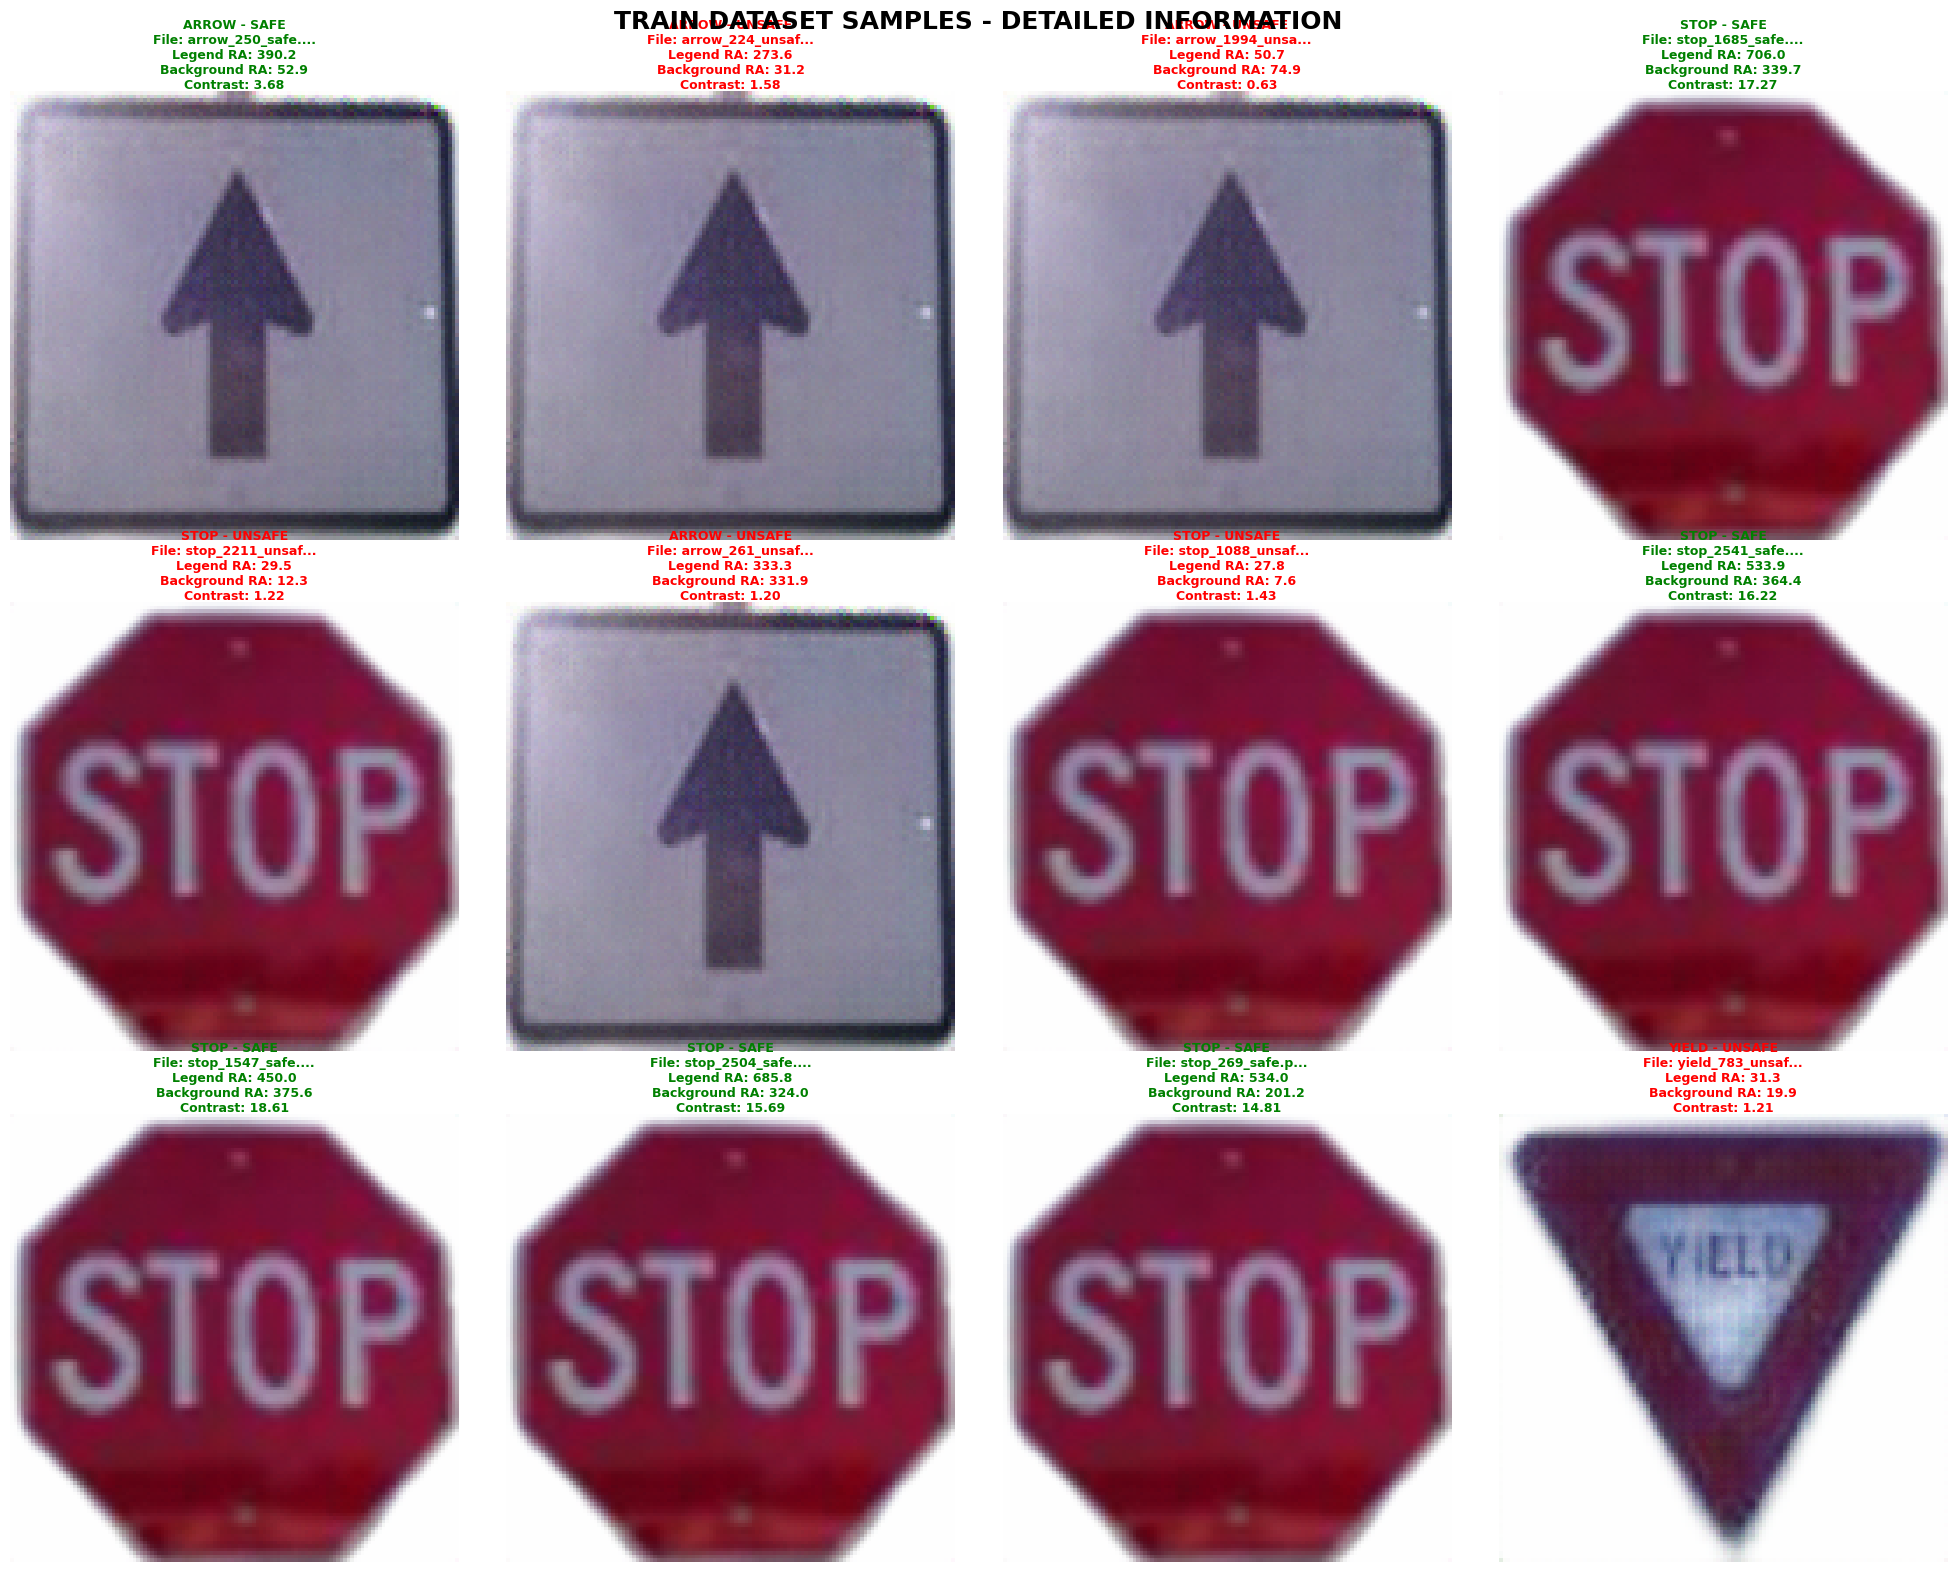

     TRAIN detailed visualization saved: train_detailed_samples_visualization.png
     TRAIN detailed summary saved: train_detailed_summary.txt
   Creating detailed test visualization...


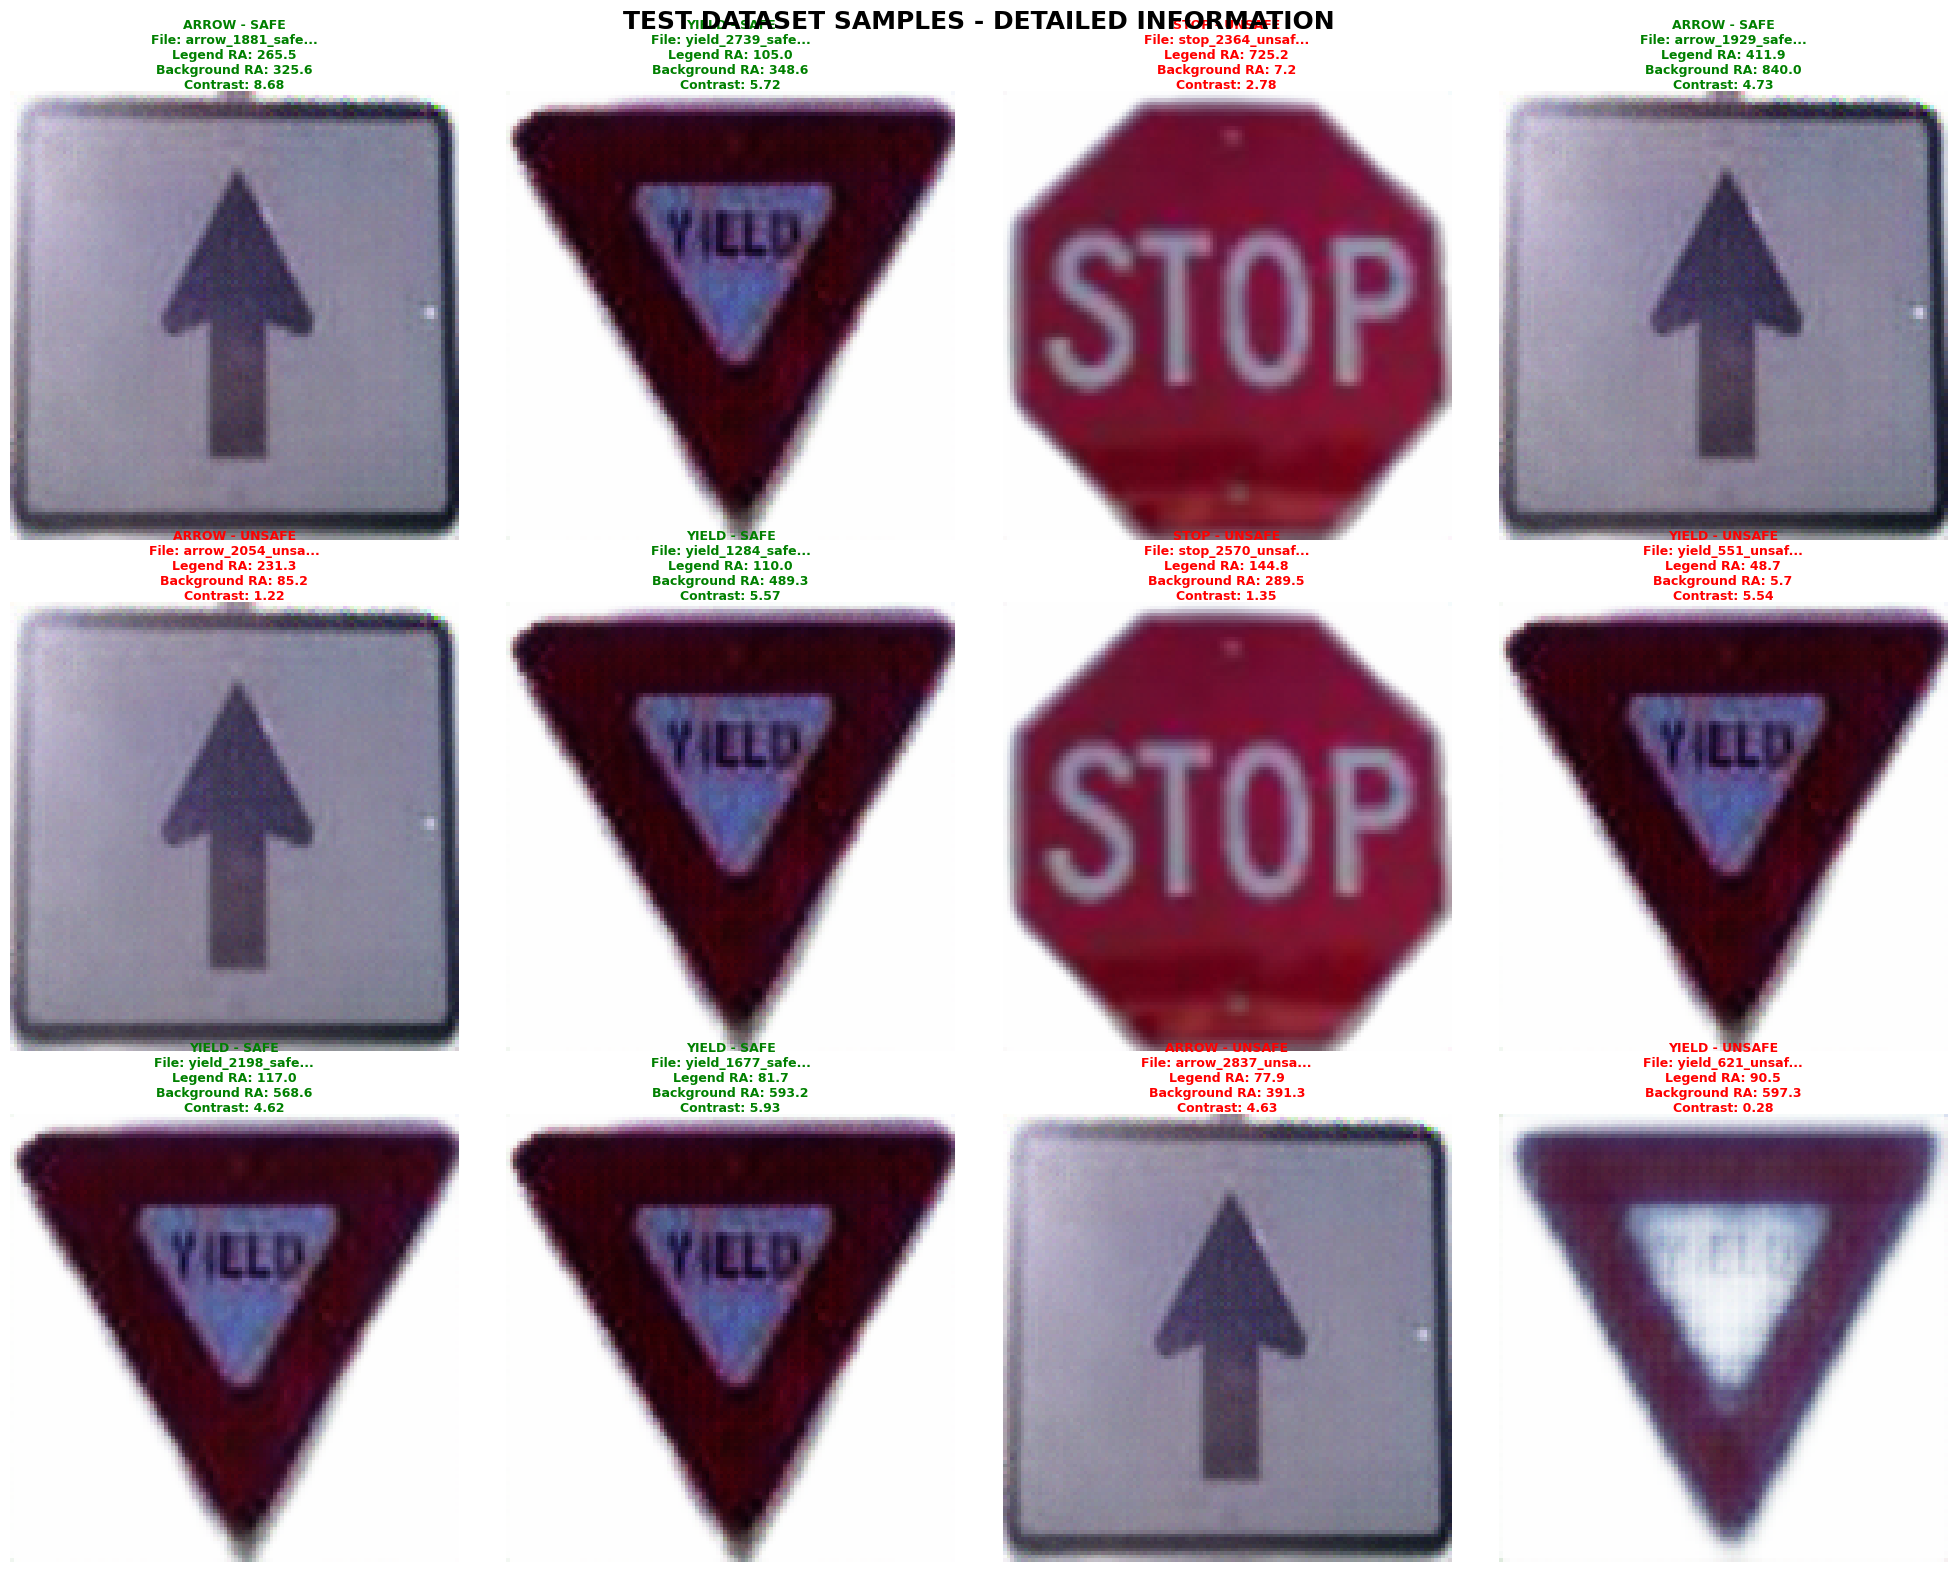

     TEST detailed visualization saved: test_detailed_samples_visualization.png
     TEST detailed summary saved: test_detailed_summary.txt
   Creating detailed validation visualization...


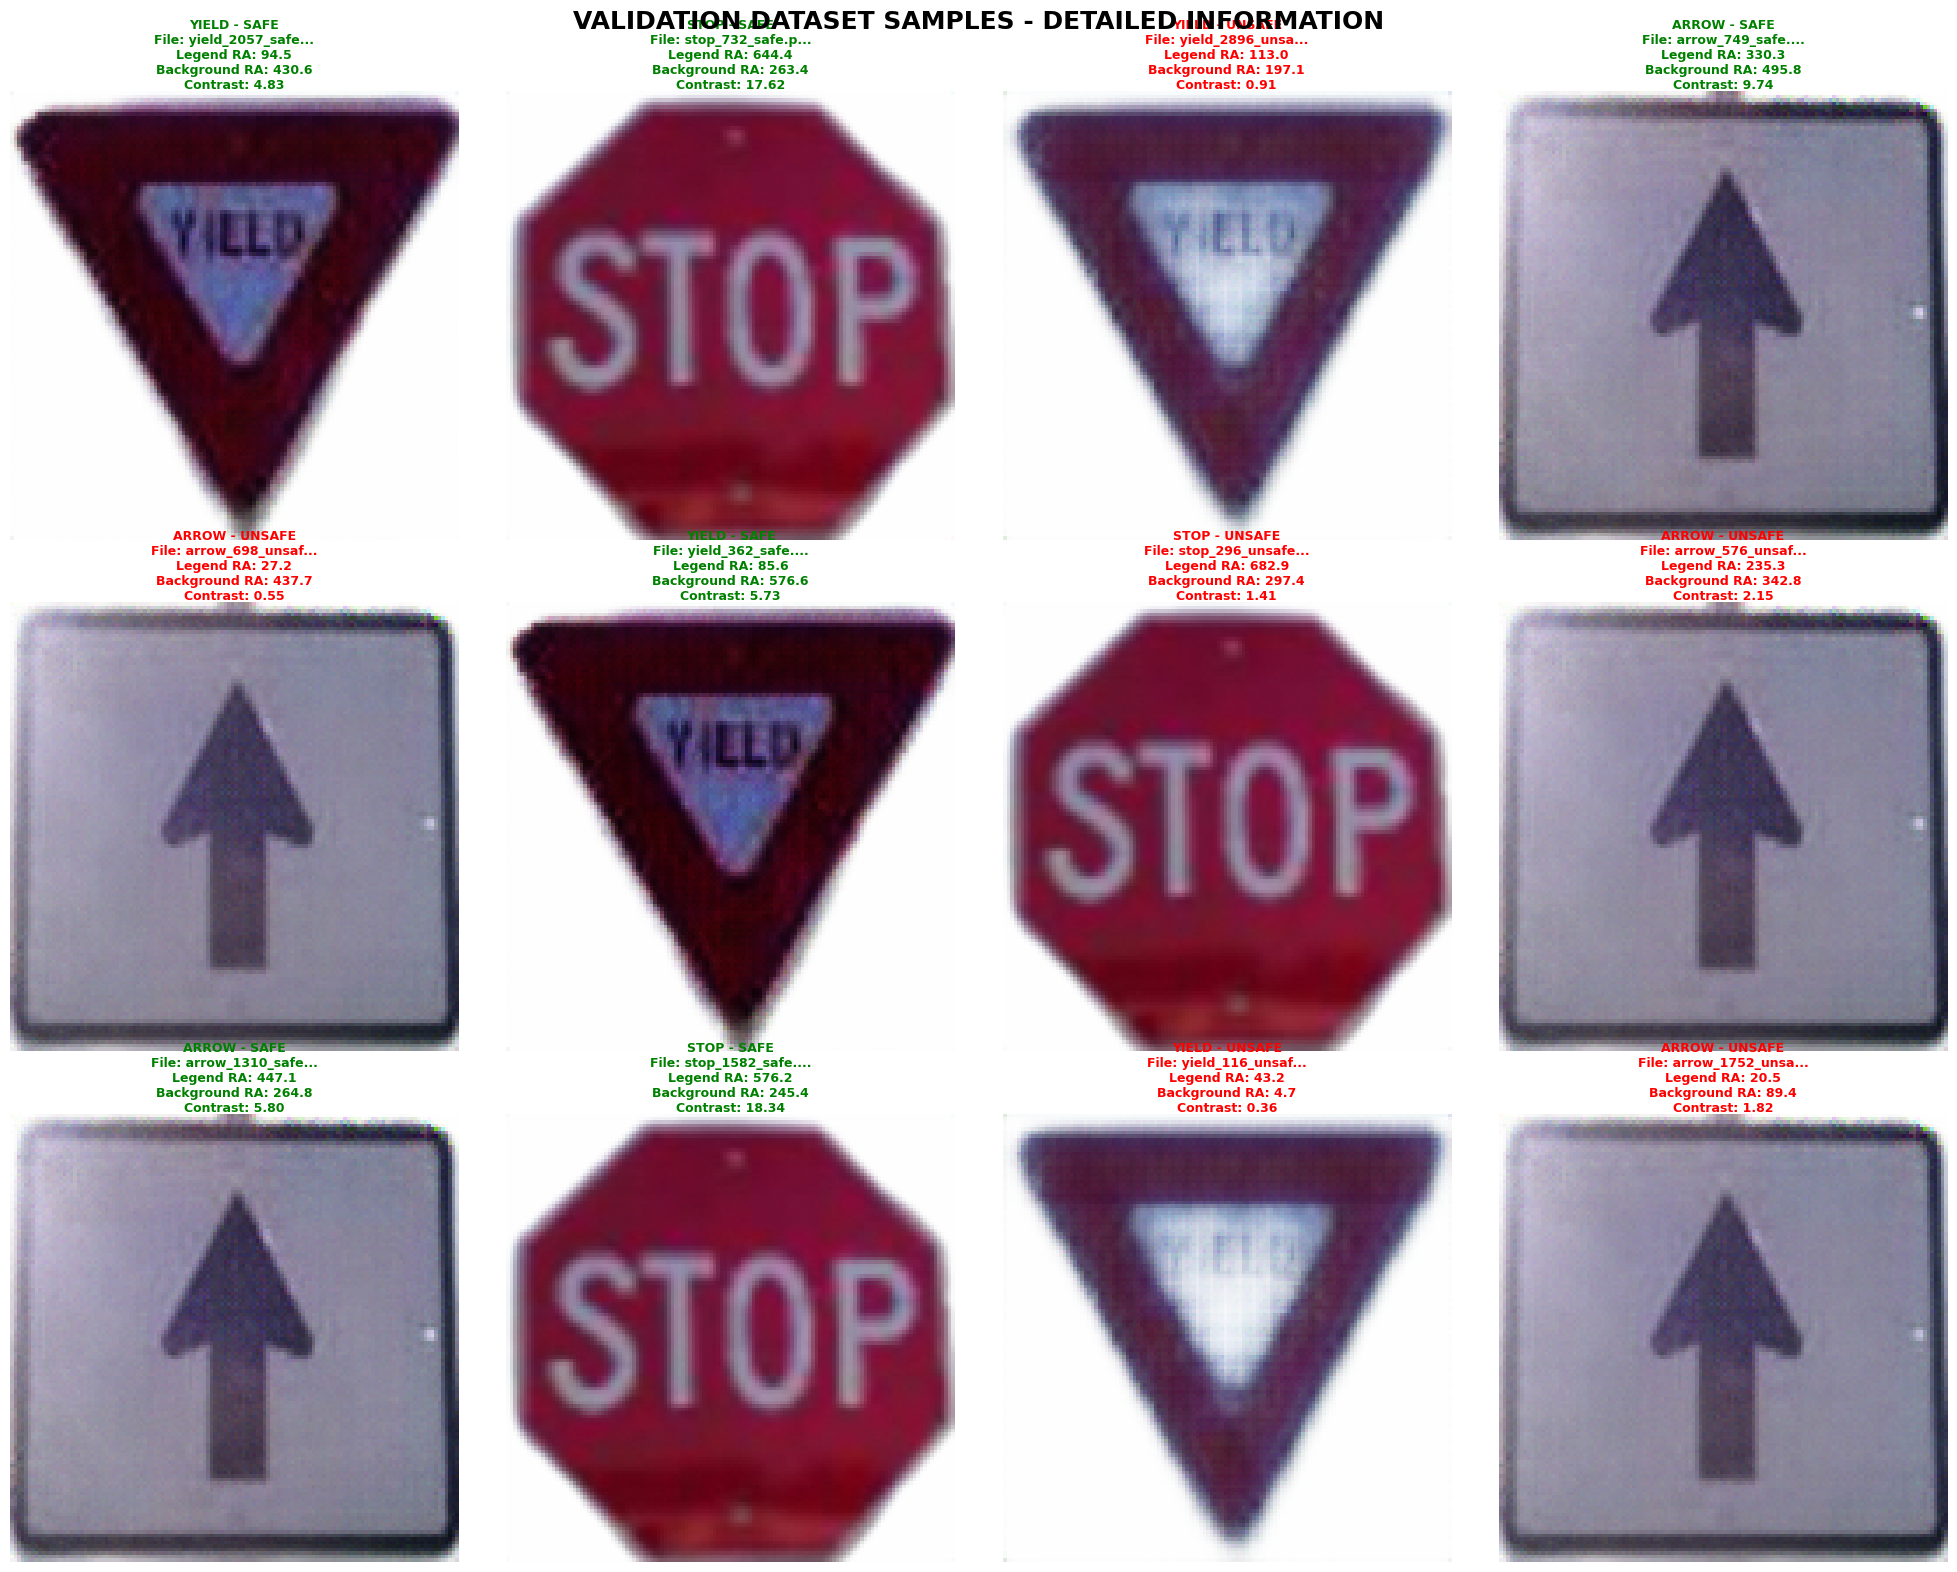

     VALIDATION detailed visualization saved: validation_detailed_samples_visualization.png
     VALIDATION detailed summary saved: validation_detailed_summary.txt
   Detailed visualization creation complete

COMPLETE TRAFFIC SIGN ORGANIZATION FINISHED!
Main directory: /content/drive/MyDrive/traffic_sign_samples
Total files processed: 10133
Ready for CNN training!

VERIFICATION CHECK
----------------------------------------
Main directory PNG files: 10133
safe directory: 3781 PNG files, 1 CSV files, 0 visualizations, 0 summaries
unsafe directory: 5219 PNG files, 1 CSV files, 0 visualizations, 0 summaries
train directory: 6300 PNG files, 1 CSV files, 1 visualizations, 1 summaries
test directory: 1350 PNG files, 1 CSV files, 1 visualizations, 1 summaries
validation directory: 1353 PNG files, 1 CSV files, 1 visualizations, 1 summaries
Required files check:
  Found: balanced_replica_traffic_signs_dataset.csv
  Found: dataset_organization_summary.txt

TRAFFIC SIGN DATASET ORGANIZATION COMPL

In [7]:
import os
import shutil
import pandas as pd
from datetime import datetime
import glob
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

# Mount Google Drive
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully")

def consolidate_and_organize_traffic_signs():
    """
    Complete pipeline to consolidate, organize, and split traffic sign datasets
    """
    # Source directories
    source_dirs_map = {
        "arrow": "/content/arrow_replicas_balanced",
        "stop": "/content/stop_replicas_balanced",
        "yield": "/content/yield_replicas_balanced"
    }

    # Metadata files for each source
    metadata_files = {
        "arrow": "balanced_replica_dataset_arrow_signs.csv",
        "stop": "balanced_replica_dataset_stop_signs.csv",
        "yield": "balanced_replica_dataset.csv"
    }

    # Main destination directory
    main_dest_dir = "/content/drive/MyDrive/traffic_sign_samples"

    # Verify Google Drive is accessible
    print("Verifying Google Drive access...")
    if not os.path.exists("/content/drive/MyDrive"):
        print("ERROR: Google Drive not accessible. Please ensure it's mounted correctly.")
        return
    print("Google Drive access confirmed")

    # Clean and create main directory
    print("Setting up main directory...")
    if os.path.exists(main_dest_dir):
        print(f"Removing existing directory: {main_dest_dir}")
        shutil.rmtree(main_dest_dir)

    print(f"Creating main directory: {main_dest_dir}")
    os.makedirs(main_dest_dir, exist_ok=True)
    print("Main directory setup complete")

    # Step 1: Consolidate all files and metadata
    print("\n=== STEP 1: CONSOLIDATING ALL TRAFFIC SIGNS ===")
    consolidated_df, total_files = consolidate_all_files(source_dirs_map, metadata_files, main_dest_dir)

    if consolidated_df.empty:
        print("ERROR: No files consolidated!")
        return

    # Step 2: Create safe/unsafe directories
    print("\n=== STEP 2: ORGANIZING BY SAFETY STATUS ===")
    safe_dir, unsafe_dir = create_safety_directories(main_dest_dir, consolidated_df)

    # Step 3: Create train/test/validation splits
    print("\n=== STEP 3: CREATING TRAIN/TEST/VALIDATION SPLITS ===")
    split_metadata = create_balanced_splits(safe_dir, unsafe_dir, main_dest_dir, consolidated_df)

    # Step 4: Visualize final results
    print("\n=== STEP 4: CREATING DETAILED VISUALIZATION ===")
    visualize_final_splits(main_dest_dir, split_metadata)

    print(f"\n{'='*80}")
    print("COMPLETE TRAFFIC SIGN ORGANIZATION FINISHED!")
    print(f"{'='*80}")
    print(f"Main directory: {main_dest_dir}")
    print(f"Total files processed: {total_files}")
    print("Ready for CNN training!")

def consolidate_all_files(source_dirs_map, metadata_files, dest_dir):
    """Step 1: Consolidate all files into single directory"""

    print("Starting file consolidation...")
    consolidated_metadata = []
    copy_count = 0

    for sign_type, source_dir in source_dirs_map.items():
        print(f"\nProcessing {sign_type.upper()} signs...")

        if not os.path.exists(source_dir):
            print(f"   Warning: {source_dir} not found. Skipping {sign_type.upper()}")
            continue

        print(f"   Source directory: {source_dir}")

        # Get all PNG files
        print("   Scanning for PNG files...")
        all_png_files = glob.glob(os.path.join(source_dir, "*.png"))
        print(f"   Found {len(all_png_files)} PNG files")

        if not all_png_files:
            print("   No PNG files found - skipping")
            continue

        # Copy all files with progress
        print("   Starting file copy operation...")
        copied_files = []
        for i, png_file in enumerate(all_png_files, 1):
            original_filename = os.path.basename(png_file)
            dest_path = os.path.join(dest_dir, original_filename)

            try:
                shutil.copy2(png_file, dest_path)
                copied_files.append(original_filename)
                copy_count += 1

                # Progress reporting every 10 files
                if i % 10 == 0 or i == len(all_png_files):
                    print(f"     Copied {i}/{len(all_png_files)} files")

            except Exception as e:
                print(f"     Error copying {original_filename}: {e}")

        print(f"   File copy complete: {len(copied_files)} files copied")

        # Process metadata
        print("   Processing metadata...")
        csv_file = os.path.join(source_dir, metadata_files[sign_type])
        if os.path.exists(csv_file):
            print(f"   Loading metadata from: {os.path.basename(csv_file)}")
            df = pd.read_csv(csv_file)

            # Filter to only copied files
            df_filtered = df[df['Filename'].isin(copied_files)].copy()

            # Ensure consistent columns
            df_filtered['Sign_Type'] = sign_type.upper()

            consolidated_metadata.append(df_filtered)
            print(f"   Metadata processed: {len(df_filtered)} records added")
        else:
            print(f"   Warning: Metadata file not found: {csv_file}")

    # Create consolidated metadata file
    print("\nCreating consolidated metadata file...")
    if consolidated_metadata:
        print("   Combining metadata from all sources...")
        consolidated_df = pd.concat(consolidated_metadata, ignore_index=True)

        # Save consolidated metadata
        csv_output_path = os.path.join(dest_dir, "balanced_replica_traffic_signs_dataset.csv")
        print(f"   Saving consolidated metadata to: {os.path.basename(csv_output_path)}")
        consolidated_df.to_csv(csv_output_path, index=False)
        print("   Consolidated metadata file created successfully")

        print(f"\nConsolidation Results:")
        print(f"   Total files copied: {copy_count}")
        print(f"   Total metadata records: {len(consolidated_df)}")

        # Show distribution
        print(f"   Distribution by sign type:")
        for sign_type in consolidated_df['Sign_Type'].unique():
            count = len(consolidated_df[consolidated_df['Sign_Type'] == sign_type])
            print(f"     {sign_type}: {count}")

        print(f"   Distribution by safety status:")
        if 'Safety_Status' in consolidated_df.columns:
            for status in consolidated_df['Safety_Status'].unique():
                count = len(consolidated_df[consolidated_df['Safety_Status'] == status])
                print(f"     {status}: {count}")

        return consolidated_df, copy_count
    else:
        print("   No metadata to consolidate")
        return pd.DataFrame(), copy_count

def create_safety_directories(main_dir, consolidated_df):
    """Step 2: Create safe and unsafe directories with metadata"""

    print("Creating safety-based organization...")

    safe_dir = os.path.join(main_dir, "safe")
    unsafe_dir = os.path.join(main_dir, "unsafe")

    # Clean and create directories
    print("   Setting up directories...")
    for directory in [safe_dir, unsafe_dir]:
        if os.path.exists(directory):
            print(f"     Removing existing: {os.path.basename(directory)}")
            shutil.rmtree(directory)
        print(f"     Creating directory: {os.path.basename(directory)}")
        os.makedirs(directory, exist_ok=True)

    print("   Directories created successfully")

    # Organize files by safety status
    print("   Organizing files by safety status...")
    safety_counts = {'SAFE': 0, 'UNSAFE': 0}
    safe_metadata = []
    unsafe_metadata = []

    total_records = len(consolidated_df)
    processed = 0

    for _, row in consolidated_df.iterrows():
        processed += 1
        filename = row['Filename']
        safety_status = row.get('Safety_Status', 'UNKNOWN')

        source_path = os.path.join(main_dir, filename)

        if not os.path.exists(source_path):
            print(f"     Warning: File not found: {filename}")
            continue

        try:
            if safety_status == 'SAFE':
                dest_path = os.path.join(safe_dir, filename)
                shutil.copy2(source_path, dest_path)
                safe_metadata.append(row)
                safety_counts['SAFE'] += 1

            elif safety_status == 'UNSAFE':
                dest_path = os.path.join(unsafe_dir, filename)
                shutil.copy2(source_path, dest_path)
                unsafe_metadata.append(row)
                safety_counts['UNSAFE'] += 1

            else:
                print(f"     Warning: Unknown safety status for {filename}: {safety_status}")

            # Progress reporting
            if processed % 50 == 0 or processed == total_records:
                print(f"     Processed {processed}/{total_records} files")

        except Exception as e:
            print(f"     Error processing {filename}: {e}")

    print("   File organization complete")

    # Create metadata files for safe and unsafe
    print("   Creating safety-specific metadata files...")
    if safe_metadata:
        print("     Creating safe metadata file...")
        safe_df = pd.DataFrame(safe_metadata)
        safe_csv_path = os.path.join(safe_dir, "safe_traffic_signs_metadata.csv")
        safe_df.to_csv(safe_csv_path, index=False)
        print(f"     Safe metadata created: {len(safe_df)} records")

    if unsafe_metadata:
        print("     Creating unsafe metadata file...")
        unsafe_df = pd.DataFrame(unsafe_metadata)
        unsafe_csv_path = os.path.join(unsafe_dir, "unsafe_traffic_signs_metadata.csv")
        unsafe_df.to_csv(unsafe_csv_path, index=False)
        print(f"     Unsafe metadata created: {len(unsafe_df)} records")

    print(f"   Final safety distribution: {safety_counts['SAFE']} SAFE, {safety_counts['UNSAFE']} UNSAFE")

    return safe_dir, unsafe_dir

def create_balanced_splits(safe_dir, unsafe_dir, main_dir, consolidated_df):
    """Step 3: Create balanced train/test/validation splits"""

    print("Creating train/test/validation splits...")

    # Create split directories
    split_dirs = {
        'train': os.path.join(main_dir, 'train'),
        'test': os.path.join(main_dir, 'test'),
        'validation': os.path.join(main_dir, 'validation')
    }

    # Clean and create split directories
    print("   Setting up split directories...")
    for split_name, split_dir in split_dirs.items():
        if os.path.exists(split_dir):
            print(f"     Removing existing {split_name} directory")
            shutil.rmtree(split_dir)
        print(f"     Creating {split_name} directory")
        os.makedirs(split_dir, exist_ok=True)

    print("   Split directories created")

    # Split ratios
    split_ratios = {
        'train': 0.7,      # 70%
        'test': 0.15,      # 15%
        'validation': 0.15  # 15%
    }

    split_counts = defaultdict(lambda: defaultdict(int))
    split_metadata = defaultdict(list)

    print("   Processing files for balanced splits...")

    # Process safe and unsafe files separately for balance
    for safety_status, source_dir in [('safe', safe_dir), ('unsafe', unsafe_dir)]:

        print(f"   Processing {safety_status} files...")

        # Get all files
        all_files = glob.glob(os.path.join(source_dir, "*.png"))
        random.shuffle(all_files)  # Randomize

        total_files = len(all_files)
        print(f"     Found {total_files} {safety_status} files")

        if total_files == 0:
            print(f"     No files to process for {safety_status}")
            continue

        # Calculate split sizes
        train_size = int(total_files * split_ratios['train'])
        test_size = int(total_files * split_ratios['test'])
        validation_size = total_files - train_size - test_size

        # Split files
        file_splits = {
            'train': all_files[:train_size],
            'test': all_files[train_size:train_size + test_size],
            'validation': all_files[train_size + test_size:]
        }

        print(f"     Split allocation: {train_size} train, {test_size} test, {validation_size} validation")

        # Copy files and collect metadata
        for split_name, files in file_splits.items():
            print(f"     Copying {len(files)} files to {split_name}...")
            split_dir = split_dirs[split_name]

            for i, file_path in enumerate(files, 1):
                filename = os.path.basename(file_path)
                dest_path = os.path.join(split_dir, filename)

                try:
                    shutil.copy2(file_path, dest_path)
                    split_counts[split_name][safety_status] += 1

                    # Find metadata for this file
                    file_metadata = consolidated_df[consolidated_df['Filename'] == filename]
                    if not file_metadata.empty:
                        split_metadata[split_name].append(file_metadata.iloc[0])

                    # Progress for large batches
                    if len(files) > 20 and i % 10 == 0:
                        print(f"       Copied {i}/{len(files)} {safety_status} files to {split_name}")

                except Exception as e:
                    print(f"       Error copying {filename} to {split_name}: {e}")

            print(f"     Completed copying {safety_status} files to {split_name}")

    # Create metadata files for each split
    print("   Creating metadata files for splits...")
    for split_name in split_dirs.keys():
        if split_metadata[split_name]:
            print(f"     Creating {split_name} metadata file...")
            split_df = pd.DataFrame(split_metadata[split_name])
            split_csv_path = os.path.join(split_dirs[split_name], f"{split_name}_metadata.csv")
            split_df.to_csv(split_csv_path, index=False)

            safe_count = split_counts[split_name]['safe']
            unsafe_count = split_counts[split_name]['unsafe']
            total_count = safe_count + unsafe_count

            print(f"     {split_name.upper()}: {total_count} files ({safe_count} safe, {unsafe_count} unsafe)")
            print(f"     Metadata saved with {len(split_df)} records")

    print("   Split creation complete")

    # Create overall summary
    create_final_summary(main_dir, split_counts, consolidated_df)

    return split_metadata

def visualize_final_splits(main_dir, split_metadata):
    """Create detailed visualization of final train/test/validation splits"""

    print("Creating detailed visualization of final splits...")

    split_dirs = {
        'train': os.path.join(main_dir, 'train'),
        'test': os.path.join(main_dir, 'test'),
        'validation': os.path.join(main_dir, 'validation')
    }

    # Create visualization for each split
    for split_name, split_dir in split_dirs.items():
        print(f"   Creating detailed {split_name} visualization...")
        create_detailed_split_visualization(split_dir, split_name, split_metadata[split_name])

    print("   Detailed visualization creation complete")

def create_detailed_split_visualization(split_dir, split_name, metadata_list):
    """Create detailed visualization for a specific split with all retro-reflectivity information"""

    if not metadata_list:
        print(f"     No metadata available for {split_name} visualization")
        return

    # Get sample images (max 12 for good display)
    png_files = glob.glob(os.path.join(split_dir, "*.png"))
    if not png_files:
        print(f"     No PNG files found in {split_dir}")
        return

    # Sample files for visualization
    sample_files = random.sample(png_files, min(12, len(png_files)))

    # Create metadata lookup
    metadata_df = pd.DataFrame(metadata_list)

    # Create figure with larger size to accommodate detailed labels
    fig, axes = plt.subplots(3, 4, figsize=(20, 16))
    fig.suptitle(f'{split_name.upper()} DATASET SAMPLES - DETAILED INFORMATION', fontsize=18, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(sample_files):
            file_path = sample_files[i]
            filename = os.path.basename(file_path)

            try:
                # Load and display image
                img = Image.open(file_path)
                ax.imshow(img)

                # Find metadata for this file
                file_meta = metadata_df[metadata_df['Filename'] == filename]

                if not file_meta.empty:
                    # Extract all relevant information
                    sign_type = file_meta.iloc[0].get('Sign_Type', 'UNKNOWN')
                    safety_status = file_meta.iloc[0].get('Safety_Status', 'UNKNOWN')

                    # Extract retro-reflectivity values with fallback column names
                    legend_ra = file_meta.iloc[0].get('Legend_Ra',
                                file_meta.iloc[0].get('Legend Ra', 'N/A'))
                    background_ra = file_meta.iloc[0].get('Background_Ra',
                                    file_meta.iloc[0].get('Background Ra', 'N/A'))
                    contrast = file_meta.iloc[0].get('Target_Contrast',
                               file_meta.iloc[0].get('Contrast',
                               file_meta.iloc[0].get('Actual_Contrast', 'N/A')))

                    # Format values
                    if isinstance(legend_ra, (int, float)):
                        legend_ra = f"{legend_ra:.1f}"
                    if isinstance(background_ra, (int, float)):
                        background_ra = f"{background_ra:.1f}"
                    if isinstance(contrast, (int, float)):
                        contrast = f"{contrast:.2f}"

                    # Set title color based on safety status
                    if safety_status == 'SAFE':
                        title_color = 'green'
                        status_text = 'SAFE'
                    elif safety_status == 'UNSAFE':
                        title_color = 'red'
                        status_text = 'UNSAFE'
                    else:
                        title_color = 'black'
                        status_text = 'UNKNOWN'

                    # Create detailed title with all information
                    title = f'{sign_type} - {status_text}\n' \
                           f'File: {filename[:15]}{"..." if len(filename) > 15 else ""}\n' \
                           f'Legend RA: {legend_ra}\n' \
                           f'Background RA: {background_ra}\n' \
                           f'Contrast: {contrast}'
                else:
                    title = f'{filename}\nUNKNOWN\nNo metadata available'
                    title_color = 'black'

                ax.set_title(title, color=title_color, fontweight='bold', fontsize=9,
                           verticalalignment='top', pad=10)

            except Exception as e:
                ax.text(0.5, 0.5, f'Error loading\n{filename}',
                       ha='center', va='center', transform=ax.transAxes)
                print(f"       Error loading {filename}: {e}")

        else:
            # Empty subplot
            ax.text(0.5, 0.5, 'No Image', ha='center', va='center', transform=ax.transAxes)

        ax.axis('off')

    plt.tight_layout()

    # Save detailed visualization
    viz_path = os.path.join(split_dir, f'{split_name}_detailed_samples_visualization.png')
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"     {split_name.upper()} detailed visualization saved: {os.path.basename(viz_path)}")

    # Also create a summary table for this split
    create_split_summary_table(split_dir, split_name, metadata_list)

def create_split_summary_table(split_dir, split_name, metadata_list):
    """Create a summary table showing key statistics for the split"""

    if not metadata_list:
        return

    metadata_df = pd.DataFrame(metadata_list)

    # Create summary statistics
    summary_path = os.path.join(split_dir, f'{split_name}_detailed_summary.txt')

    with open(summary_path, 'w') as f:
        f.write(f"DETAILED SUMMARY FOR {split_name.upper()} DATASET\n")
        f.write("="*50 + "\n\n")

        # Basic counts
        total_files = len(metadata_df)
        f.write(f"Total Files: {total_files}\n\n")

        # Distribution by sign type and safety
        f.write("DISTRIBUTION BY SIGN TYPE AND SAFETY:\n")
        for sign_type in ['STOP', 'YIELD', 'ARROW']:
            type_data = metadata_df[metadata_df['Sign_Type'] == sign_type]
            if len(type_data) > 0:
                safe_count = len(type_data[type_data['Safety_Status'] == 'SAFE'])
                unsafe_count = len(type_data[type_data['Safety_Status'] == 'UNSAFE'])
                f.write(f"  {sign_type}: {len(type_data)} total ({safe_count} safe, {unsafe_count} unsafe)\n")

        f.write(f"\n")

        # Retro-reflectivity statistics
        f.write("RETRO-REFLECTIVITY STATISTICS:\n")

        # Legend RA statistics
        legend_col = None
        for col in ['Legend_Ra', 'Legend Ra']:
            if col in metadata_df.columns:
                legend_col = col
                break

        if legend_col and metadata_df[legend_col].dtype in ['float64', 'int64']:
            f.write(f"  Legend RA:\n")
            f.write(f"    Min: {metadata_df[legend_col].min():.2f}\n")
            f.write(f"    Max: {metadata_df[legend_col].max():.2f}\n")
            f.write(f"    Mean: {metadata_df[legend_col].mean():.2f}\n")
            f.write(f"    Std: {metadata_df[legend_col].std():.2f}\n")

        # Background RA statistics
        background_col = None
        for col in ['Background_Ra', 'Background Ra']:
            if col in metadata_df.columns:
                background_col = col
                break

        if background_col and metadata_df[background_col].dtype in ['float64', 'int64']:
            f.write(f"  Background RA:\n")
            f.write(f"    Min: {metadata_df[background_col].min():.2f}\n")
            f.write(f"    Max: {metadata_df[background_col].max():.2f}\n")
            f.write(f"    Mean: {metadata_df[background_col].mean():.2f}\n")
            f.write(f"    Std: {metadata_df[background_col].std():.2f}\n")

        # Contrast statistics
        contrast_col = None
        for col in ['Target_Contrast', 'Contrast', 'Actual_Contrast']:
            if col in metadata_df.columns:
                contrast_col = col
                break

        if contrast_col and metadata_df[contrast_col].dtype in ['float64', 'int64']:
            f.write(f"  Contrast:\n")
            f.write(f"    Min: {metadata_df[contrast_col].min():.3f}\n")
            f.write(f"    Max: {metadata_df[contrast_col].max():.3f}\n")
            f.write(f"    Mean: {metadata_df[contrast_col].mean():.3f}\n")
            f.write(f"    Std: {metadata_df[contrast_col].std():.3f}\n")

    print(f"     {split_name.upper()} detailed summary saved: {os.path.basename(summary_path)}")

def create_final_summary(main_dir, split_counts, consolidated_df):
    """Create comprehensive summary report"""

    print("Creating final summary report...")

    summary_path = os.path.join(main_dir, "dataset_organization_summary.txt")
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    print(f"   Writing summary to: {os.path.basename(summary_path)}")

    with open(summary_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("TRAFFIC SIGN DATASET ORGANIZATION SUMMARY\n")
        f.write("="*80 + "\n")
        f.write(f"Generated: {timestamp}\n\n")

        # Overall statistics
        total_files = len(consolidated_df)
        f.write(f"OVERALL STATISTICS:\n")
        f.write(f"  Total Files: {total_files}\n")

        if 'Sign_Type' in consolidated_df.columns:
            f.write(f"  By Sign Type:\n")
            for sign_type, count in consolidated_df['Sign_Type'].value_counts().items():
                f.write(f"    {sign_type}: {count}\n")

        if 'Safety_Status' in consolidated_df.columns:
            f.write(f"  By Safety Status:\n")
            for status, count in consolidated_df['Safety_Status'].value_counts().items():
                f.write(f"    {status}: {count}\n")

        f.write(f"\n")

        # Split statistics
        f.write(f"TRAIN/TEST/VALIDATION SPLITS:\n")
        grand_total = 0
        for split_name in ['train', 'test', 'validation']:
            safe_count = split_counts[split_name]['safe']
            unsafe_count = split_counts[split_name]['unsafe']
            split_total = safe_count + unsafe_count
            grand_total += split_total

            percentage = (split_total / total_files * 100) if total_files > 0 else 0
            f.write(f"  {split_name.upper()}: {split_total} files ({percentage:.1f}%)\n")
            f.write(f"    Safe: {safe_count}, Unsafe: {unsafe_count}\n")

        f.write(f"  TOTAL SPLIT FILES: {grand_total}\n\n")

        # Directory structure
        f.write(f"DIRECTORY STRUCTURE:\n")
        f.write(f"  {main_dir}/\n")
        f.write(f"    balanced_replica_traffic_signs_dataset.csv\n")
        f.write(f"    safe/\n")
        f.write(f"      safe_traffic_signs_metadata.csv\n")
        f.write(f"    unsafe/\n")
        f.write(f"      unsafe_traffic_signs_metadata.csv\n")
        f.write(f"    train/\n")
        f.write(f"      train_metadata.csv\n")
        f.write(f"      train_detailed_samples_visualization.png\n")
        f.write(f"      train_detailed_summary.txt\n")
        f.write(f"    test/\n")
        f.write(f"      test_metadata.csv\n")
        f.write(f"      test_detailed_samples_visualization.png\n")
        f.write(f"      test_detailed_summary.txt\n")
        f.write(f"    validation/\n")
        f.write(f"      validation_metadata.csv\n")
        f.write(f"      validation_detailed_samples_visualization.png\n")
        f.write(f"      validation_detailed_summary.txt\n")
        f.write(f"    dataset_organization_summary.txt\n\n")

        f.write(f"READY FOR CNN TRAINING!\n")
        f.write("="*80 + "\n")

    print("   Summary report created successfully")

def verify_organization(main_dir):
    """Verify the complete organization"""
    print(f"\nVERIFICATION CHECK")
    print("-" * 40)

    # Check main directory
    main_files = glob.glob(os.path.join(main_dir, "*.png"))
    print(f"Main directory PNG files: {len(main_files)}")

    # Check subdirectories
    subdirs = ['safe', 'unsafe', 'train', 'test', 'validation']
    for subdir in subdirs:
        subdir_path = os.path.join(main_dir, subdir)
        if os.path.exists(subdir_path):
            png_files = glob.glob(os.path.join(subdir_path, "*.png"))
            csv_files = glob.glob(os.path.join(subdir_path, "*.csv"))
            viz_files = glob.glob(os.path.join(subdir_path, "*visualization.png"))
            summary_files = glob.glob(os.path.join(subdir_path, "*summary.txt"))
            print(f"{subdir} directory: {len(png_files)} PNG files, {len(csv_files)} CSV files, {len(viz_files)} visualizations, {len(summary_files)} summaries")
        else:
            print(f"{subdir} directory: NOT FOUND")

    # Check required files
    required_files = [
        "balanced_replica_traffic_signs_dataset.csv",
        "dataset_organization_summary.txt"
    ]

    print("Required files check:")
    for req_file in required_files:
        file_path = os.path.join(main_dir, req_file)
        if os.path.exists(file_path):
            print(f"  Found: {req_file}")
        else:
            print(f"  MISSING: {req_file}")

if __name__ == "__main__":
    try:
        consolidate_and_organize_traffic_signs()

        # Verify the results
        main_dest_dir = "/content/drive/MyDrive/traffic_sign_samples"
        verify_organization(main_dest_dir)

        print(f"\n{'='*80}")
        print("TRAFFIC SIGN DATASET ORGANIZATION COMPLETE!")
        print(f"{'='*80}")
        print(f"Location: {main_dest_dir}")
        print("All files organized by safety status and split for CNN training!")
        print("Detailed visualizations created with retro-reflectivity values!")
        print("Summary statistics generated for each split!")

    except Exception as e:
        print(f"Error during organization: {str(e)}")
        import traceback
        traceback.print_exc()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TRAFFIC SIGN SAFETY CLASSIFICATION WITH DEBUGGING
Loading datasets from: /content/drive/MyDrive/traffic_sign_samples

DEBUGGING DIRECTORY: /content/drive/MyDrive/traffic_sign_samples/train
--------------------------------------------------
Total files: 6302
Image files: 6300
CSV files: 1

DEBUGGING CSV: /content/drive/MyDrive/traffic_sign_samples/train/train_metadata.csv
--------------------------------------------------
CSV Shape: (6299, 18)
Columns: ['Filename', 'Sign_Type', 'MUTCD_Code', 'Legend_Ra', 'Background_Ra', 'Target_Contrast', 'Actual_Reflectivity', 'Actual_Contrast', 'Safety_Status', 'Variation_Type', 'MUTCD_Compliant', 'Delta_R', 'Delta_C', 'Latitude', 'Longitude', 'Age_Years', 'Sheeting_Type', 'Generated_Time']
Safety-related columns: ['Safety_Status']
Safety_Status values: Safety_Status
UNSAFE    3653
SAFE      2646
Name: count, dtype: int64



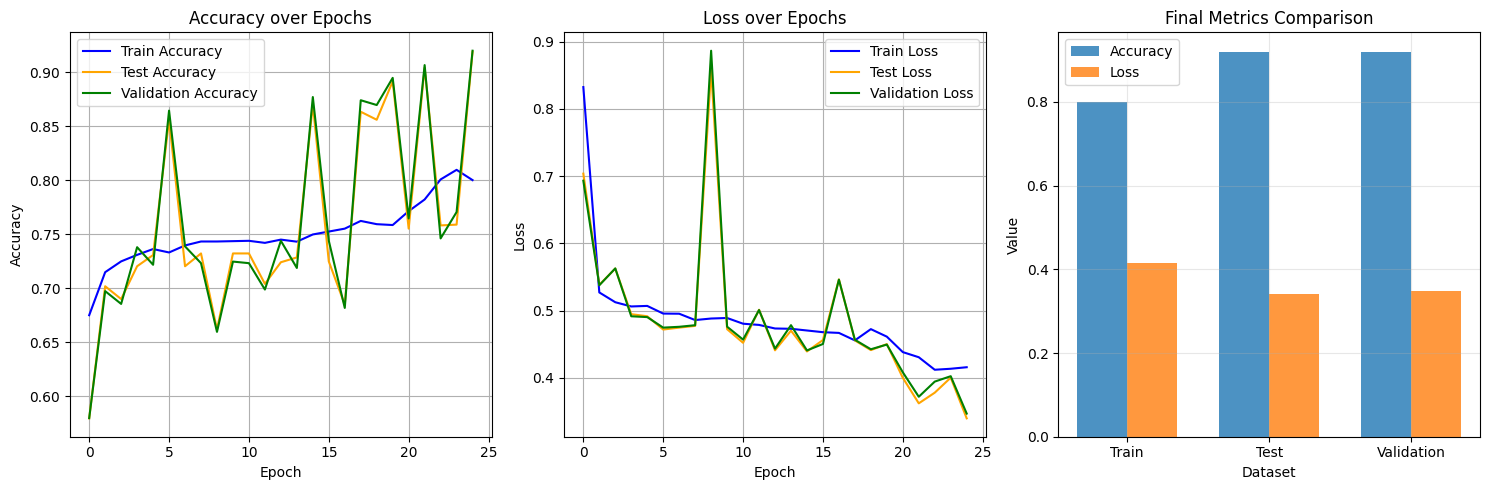


Generating sample image visualizations...
Sample images saved to: /content/drive/MyDrive/traffic_sign_samples/sample_train_predictions.png


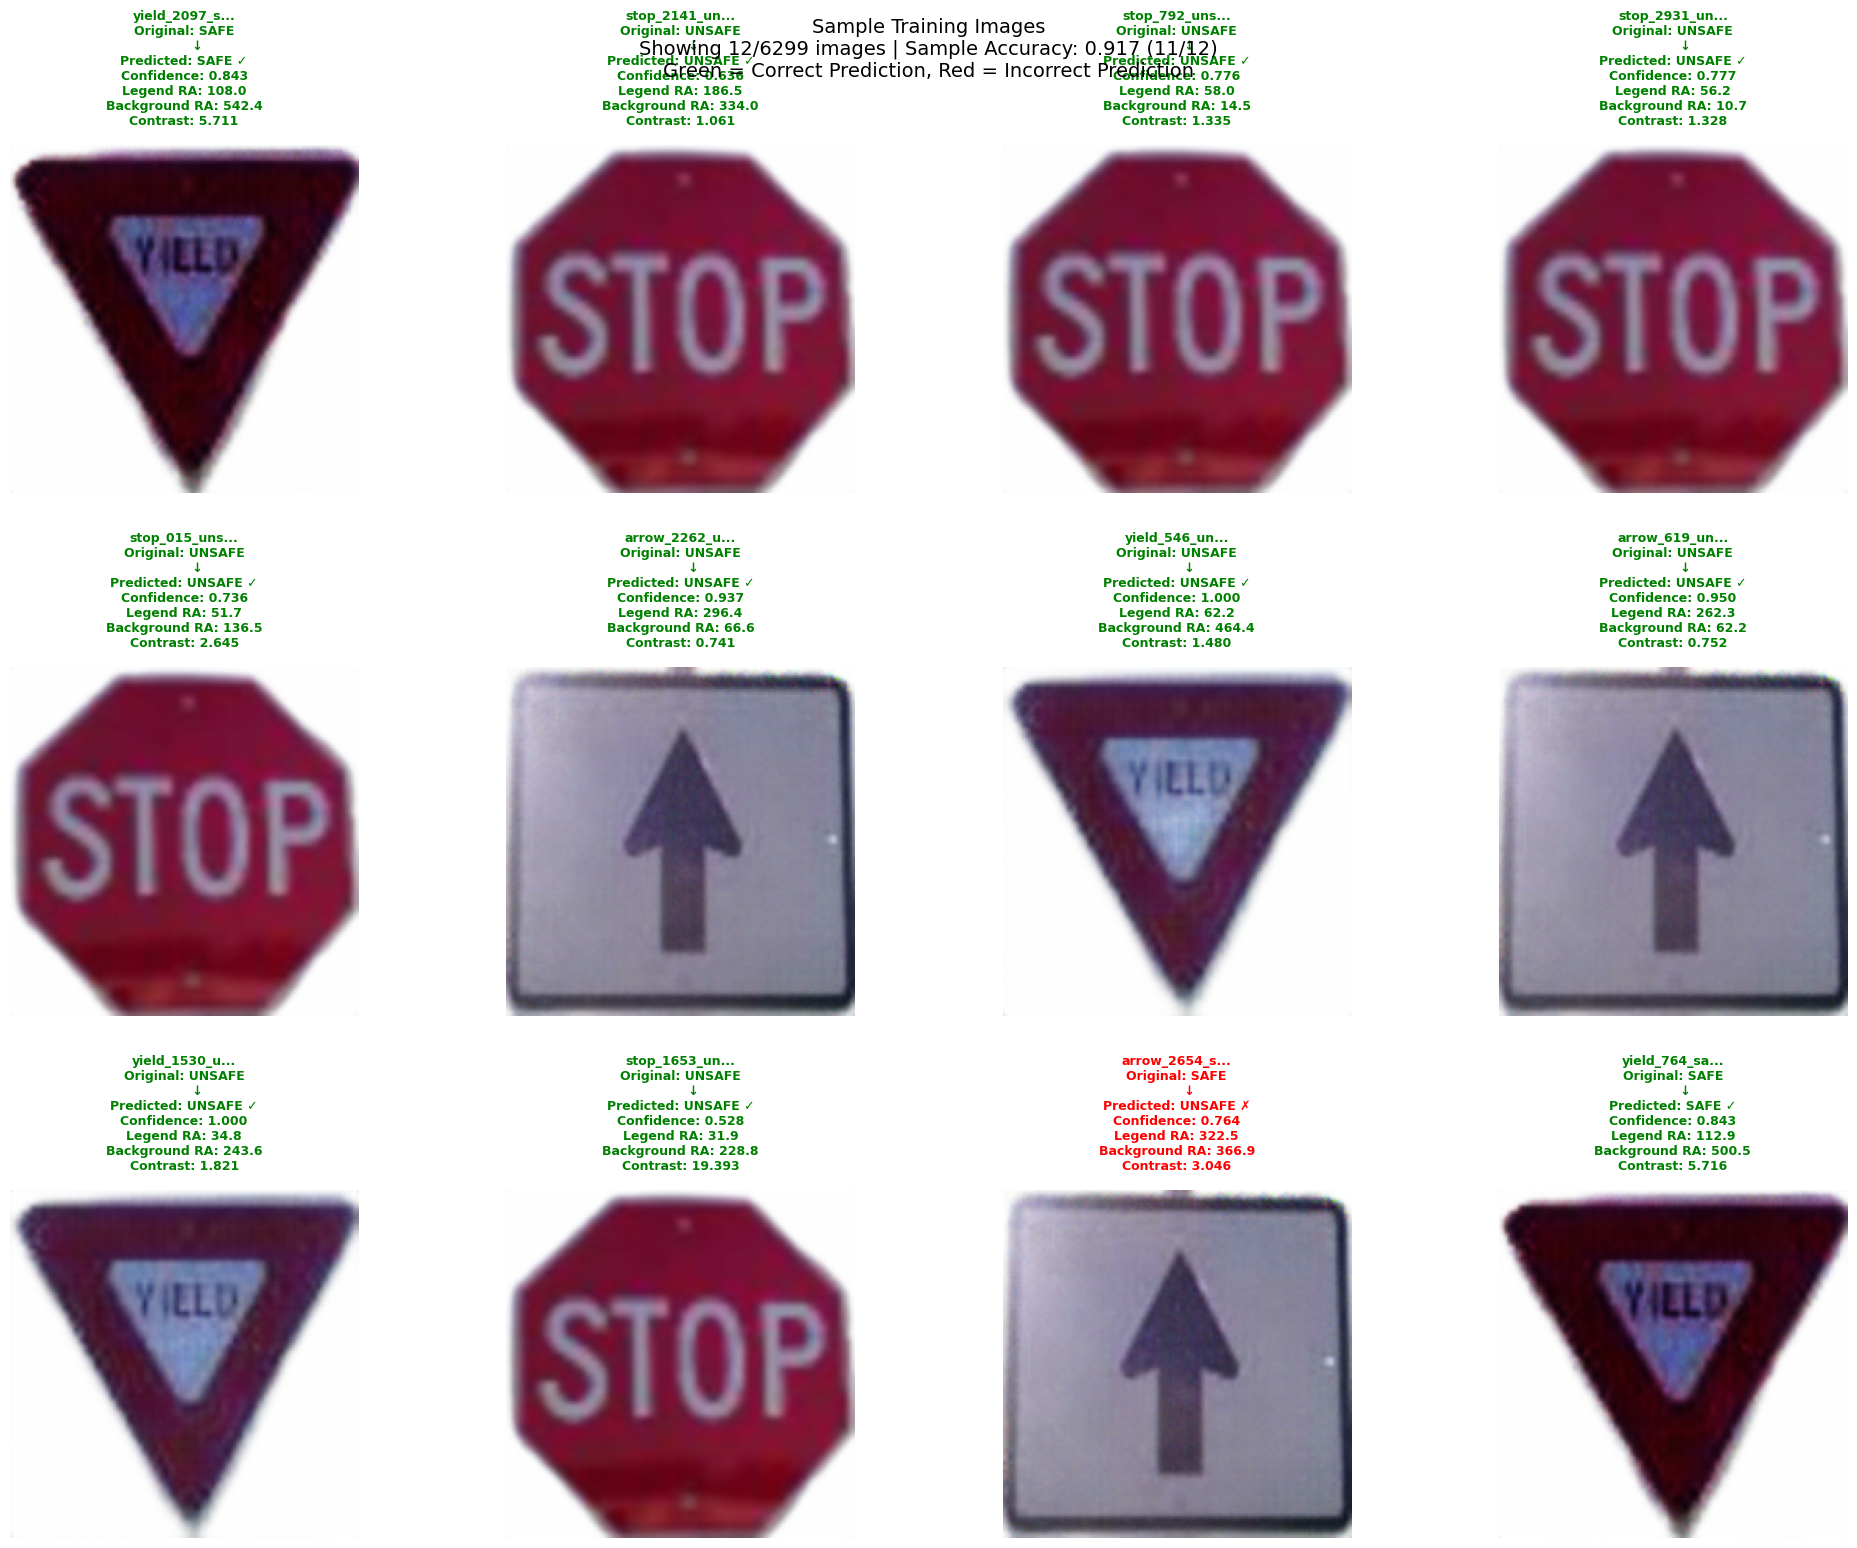

Sample images saved to: /content/drive/MyDrive/traffic_sign_samples/sample_test_predictions.png


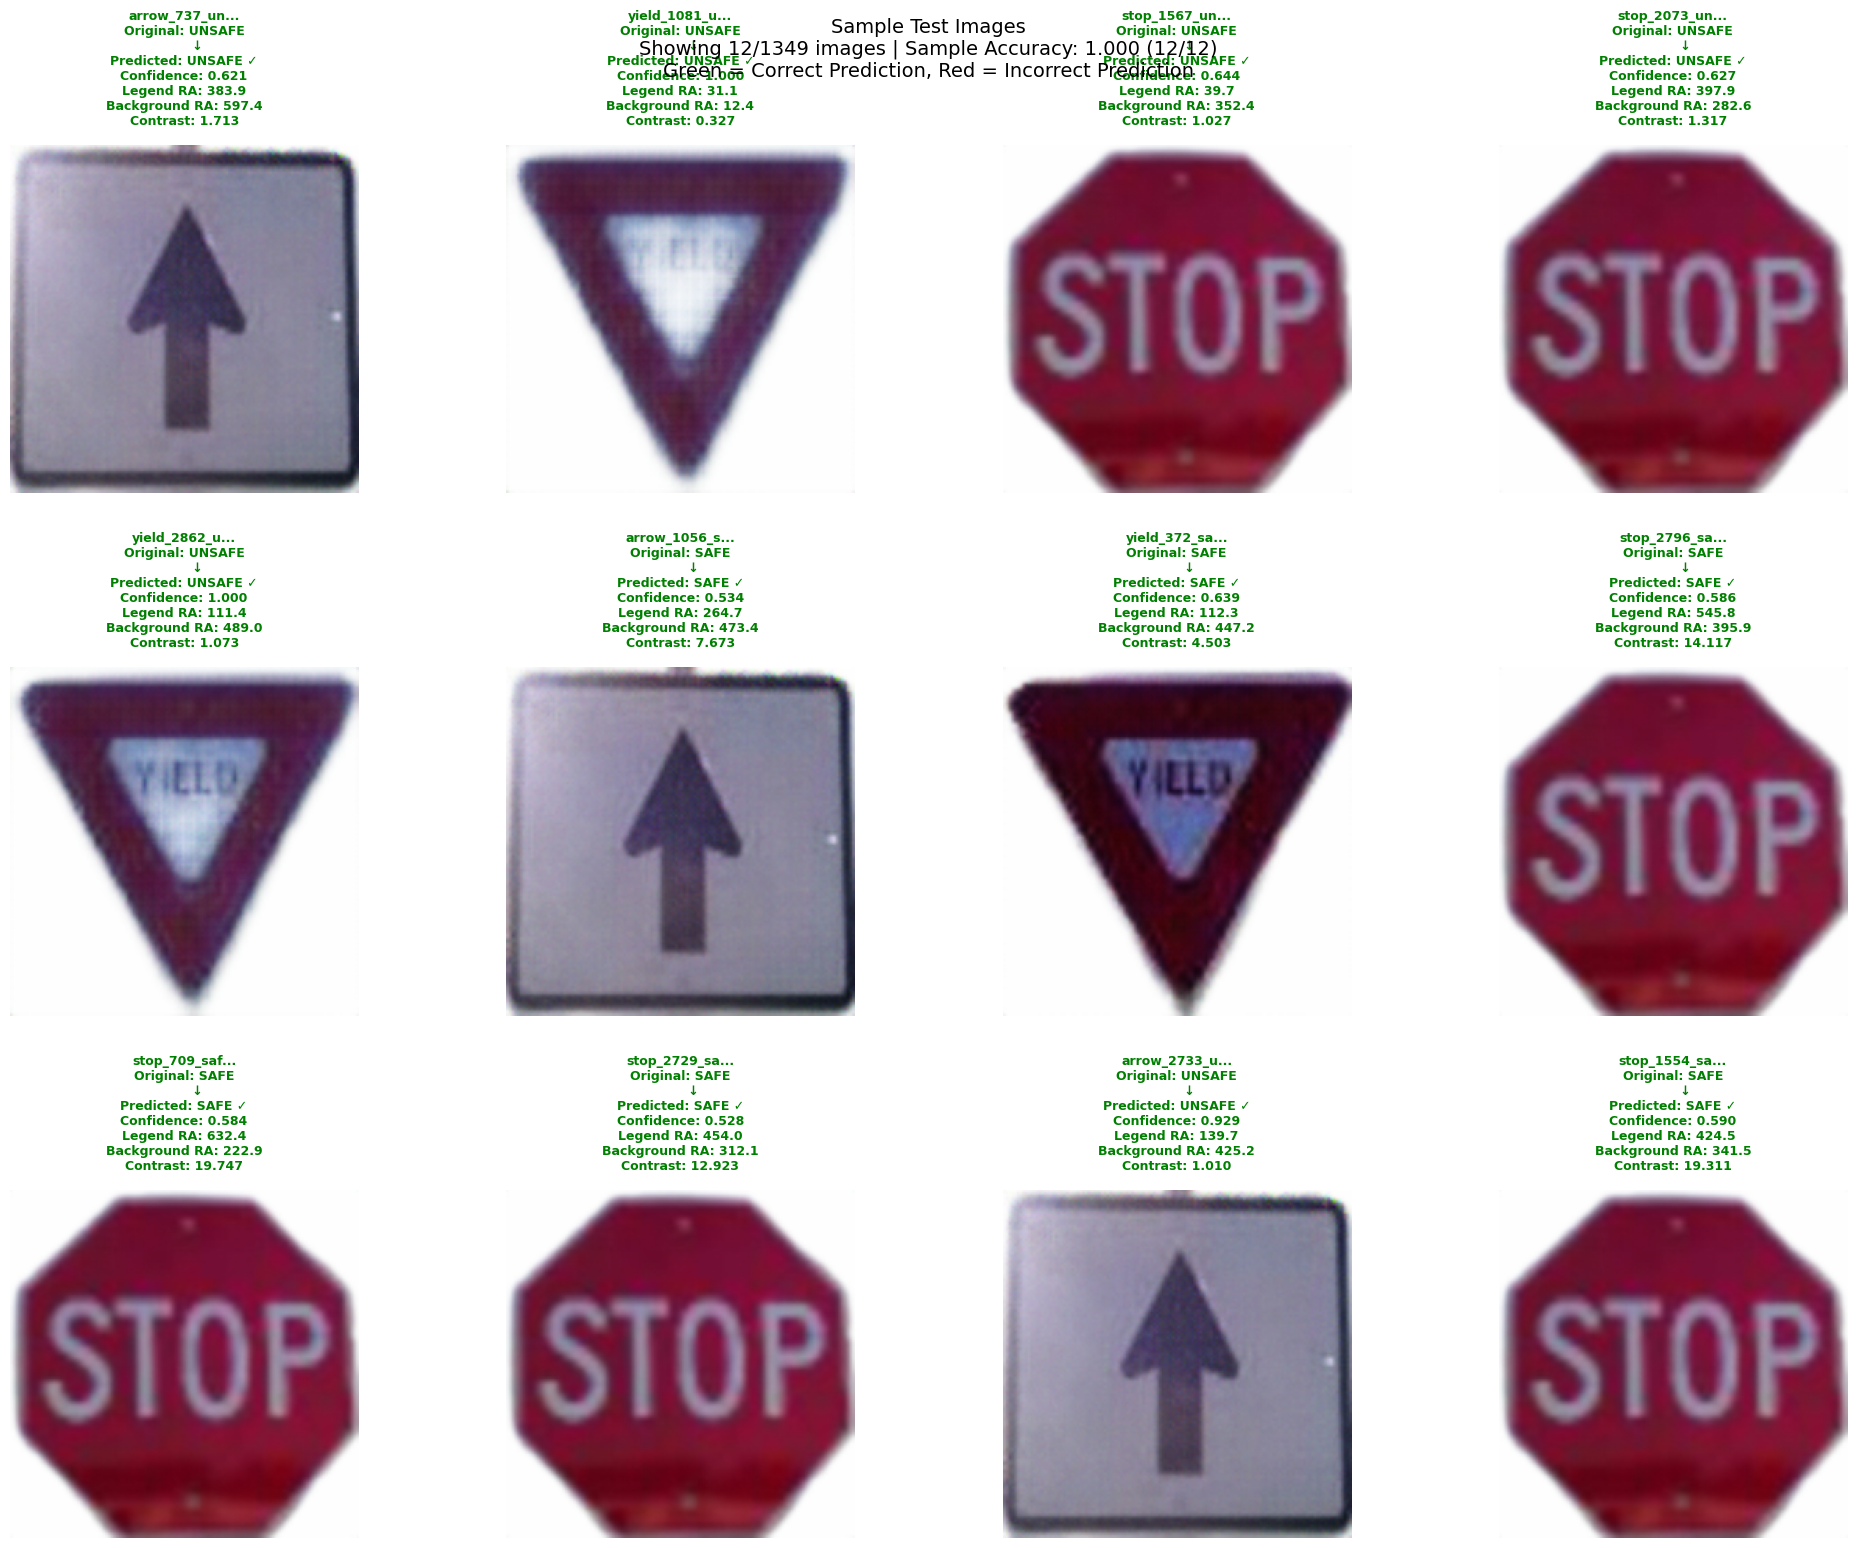

Sample images saved to: /content/drive/MyDrive/traffic_sign_samples/sample_validation_predictions.png


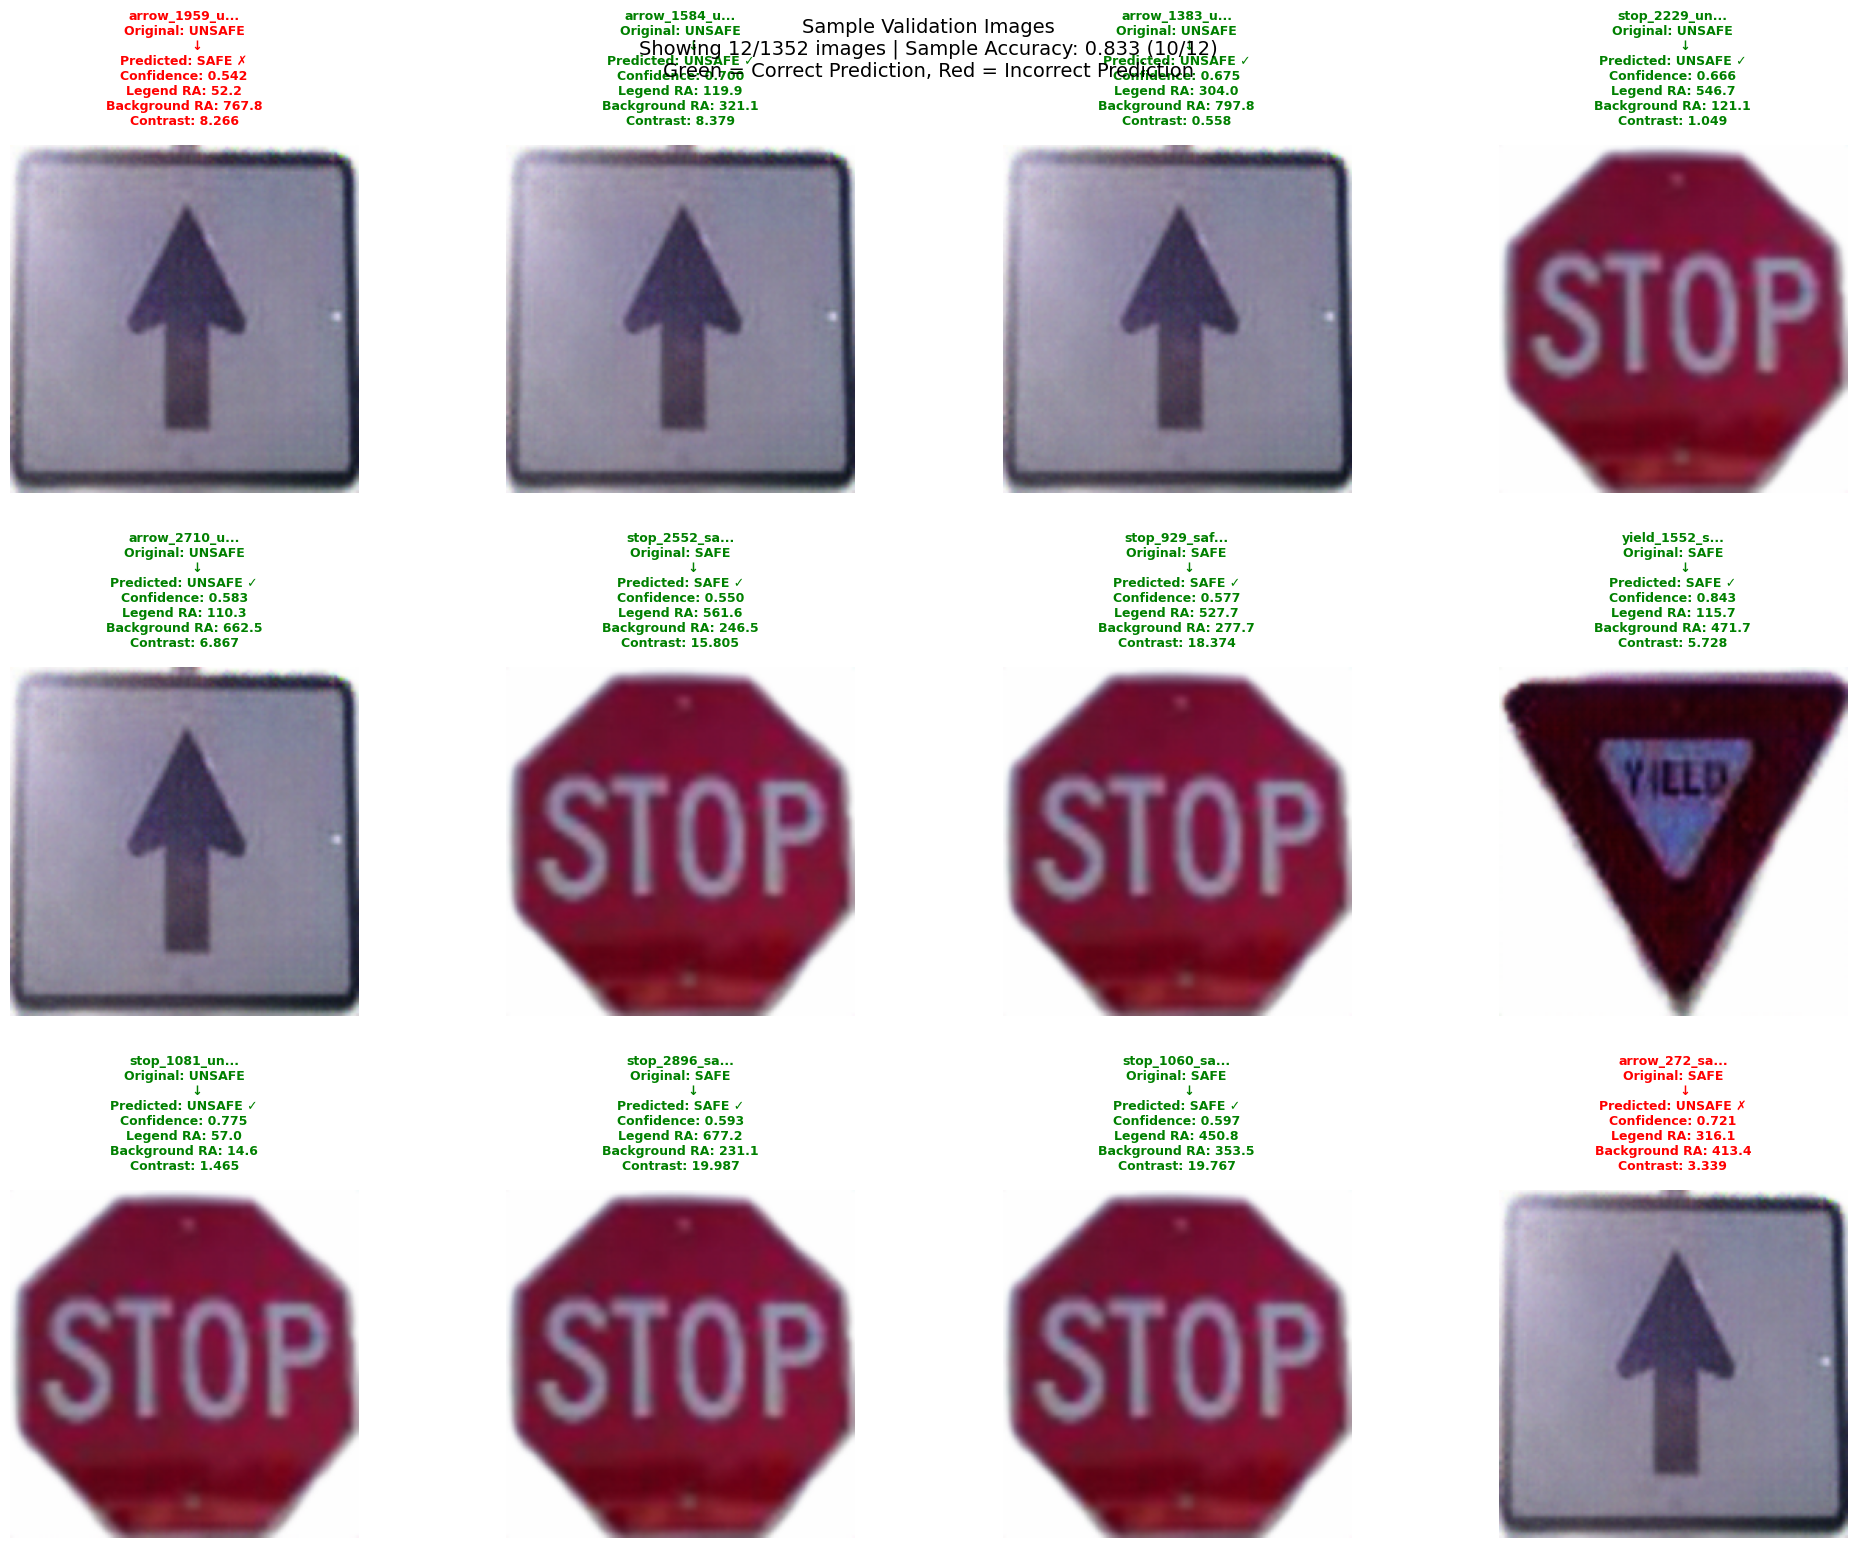


TRAINING Analysis:
  Total samples: 6299
  Correct predictions: 5375
  Accuracy: 0.8533
  Confusion Matrix:
    True Positives (SAFE correctly identified): 2022
    True Negatives (UNSAFE correctly identified): 3353
    False Positives (UNSAFE predicted as SAFE): 300
    False Negatives (SAFE predicted as UNSAFE): 624
  Precision (SAFE): 0.8708
  Recall (SAFE): 0.7642

TEST Analysis:
  Total samples: 1349
  Correct predictions: 1240
  Accuracy: 0.9192
  Confusion Matrix:
    True Positives (SAFE correctly identified): 481
    True Negatives (UNSAFE correctly identified): 759
    False Positives (UNSAFE predicted as SAFE): 23
    False Negatives (SAFE predicted as UNSAFE): 86
  Precision (SAFE): 0.9544
  Recall (SAFE): 0.8483

VALIDATION Analysis:
  Total samples: 1352
  Correct predictions: 1244
  Accuracy: 0.9201
  Confusion Matrix:
    True Positives (SAFE correctly identified): 492
    True Negatives (UNSAFE correctly identified): 752
    False Positives (UNSAFE predicted as SAFE):

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# === Enhanced debugging functions ===
def debug_csv_structure(csv_path):
    """Debug CSV file structure and contents"""
    print(f"\nDEBUGGING CSV: {csv_path}")
    print("-" * 50)

    if not os.path.exists(csv_path):
        print(f"ERROR: CSV file not found!")
        return None

    df = pd.read_csv(csv_path)
    print(f"CSV Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Check for safety status column
    safety_columns = [col for col in df.columns if 'safety' in col.lower() or 'status' in col.lower()]
    print(f"Safety-related columns: {safety_columns}")

    # Check Safety_Status values
    if 'Safety_Status' in df.columns:
        print(f"Safety_Status values: {df['Safety_Status'].value_counts()}")

    return df

def debug_directory_structure(directory):
    """Debug directory contents"""
    print(f"\nDEBUGGING DIRECTORY: {directory}")
    print("-" * 50)

    if not os.path.exists(directory):
        print(f"ERROR: Directory not found!")
        return []

    all_files = os.listdir(directory)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    csv_files = [f for f in all_files if f.lower().endswith('.csv')]

    print(f"Total files: {len(all_files)}")
    print(f"Image files: {len(image_files)}")
    print(f"CSV files: {len(csv_files)}")

    return image_files

def load_label_map_from_csv(csv_path):
    """Load labels from split metadata CSV files with debugging"""
    label_map = {}
    if not os.path.exists(csv_path):
        print(f"WARNING: Metadata CSV not found at {csv_path}")
        return label_map

    print(f"Loading labels from: {csv_path}")
    df = pd.read_csv(csv_path)

    # Try different possible column names for safety status
    safety_col = None
    possible_safety_cols = ['Safety_Status', 'safety_status', 'Status', 'MUTCD_Compliant', 'mutcd_compliant']

    for col in possible_safety_cols:
        if col in df.columns:
            safety_col = col
            break

    if safety_col is None:
        print(f"   ERROR: No safety status column found!")
        print(f"   Available columns: {list(df.columns)}")
        return label_map

    print(f"   Using safety column: {safety_col}")
    unique_values = df[safety_col].unique()
    print(f"   Unique safety values: {unique_values}")

    safe_count = 0
    unsafe_count = 0

    for _, row in df.iterrows():
        fname = row['Filename']
        safety_value = str(row.get(safety_col, 'UNKNOWN')).upper()

        if safety_value in ['SAFE', 'YES', '1', 'TRUE']:
            label_map[fname] = 1
            safe_count += 1
        elif safety_value in ['UNSAFE', 'NO', '0', 'FALSE']:
            label_map[fname] = 0
            unsafe_count += 1

    print(f"   Loaded labels: {safe_count} SAFE, {unsafe_count} UNSAFE")
    return label_map

def load_rc_map_from_csv(csv_path):
    """Load retro-reflectivity values from split metadata CSV files"""
    rc_map = {}
    if not os.path.exists(csv_path):
        print(f"Warning: Metadata CSV not found at {csv_path}")
        return rc_map

    print(f"Loading R/C values from: {csv_path}")
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        fname = row['Filename']

        # Try different column name variations
        legend_ra = row.get('Legend_Ra', row.get('Legend Ra', 'N/A'))
        bg_ra = row.get('Background_Ra', row.get('Background Ra', 'N/A'))
        contrast = row.get('Target_Contrast', row.get('Contrast', row.get('Actual_Contrast', 'N/A')))

        rc_map[fname] = (legend_ra, bg_ra, contrast)

    print(f"   Loaded R/C values for {len(rc_map)} files")
    return rc_map

def verify_dataset_balance(label_map):
    """Check if dataset is balanced"""
    if not label_map:
        print("ERROR: No labels loaded!")
        return

    safe_count = sum(1 for label in label_map.values() if label == 1)
    unsafe_count = sum(1 for label in label_map.values() if label == 0)

    print(f"   SAFE (1): {safe_count} ({safe_count/len(label_map)*100:.1f}%)")
    print(f"   UNSAFE (0): {unsafe_count} ({unsafe_count/len(label_map)*100:.1f}%)")

# === Enhanced Dataset ===
class TrafficSignDataset(Dataset):
    def __init__(self, directory, label_map, transform=None):
        self.directory = directory
        self.transform = transform
        self.label_map = label_map

        all_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.images = [f for f in all_files if f in label_map]

        print(f"   Dataset: {len(all_files)} total images, {len(self.images)} with labels")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        fname = self.images[idx]
        path = os.path.join(self.directory, fname)

        try:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.label_map[fname]
            return image, label, fname
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            dummy_image = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224))
            return dummy_image, 0, fname

# === Enhanced CNN for Traffic Signs ===
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(TrafficSignCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# === Training with Validation ===
def train_model(model, train_loader, test_loader, val_loader, device, epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_accs, test_accs, val_accs = [], [], []
    train_losses, test_losses, val_losses = [], [], []

    print(f"Starting training for {epochs} epochs...")
    print(f"Training on: {device}")

    for epoch in range(epochs):
        # Training
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for batch_idx, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Debug first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"First batch - Images: {images.shape}, Labels: {labels}")
                print(f"Label distribution: {torch.bincount(labels)}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()

        train_acc = correct / total
        train_loss = loss_sum / len(train_loader)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Testing
        test_acc, test_loss = evaluate_model(model, test_loader, criterion, device)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        # Validation
        val_acc, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1:2d}/{epochs} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | Val: {val_acc:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    return train_accs, test_accs, val_accs, train_losses, test_losses, val_losses

def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on given data loader"""
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0

    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()

    accuracy = correct / total
    avg_loss = loss_sum / len(data_loader)
    return accuracy, avg_loss

# === Enhanced Plotting with Validation ===
def plot_training_metrics(train_acc, test_acc, val_acc, train_loss, test_loss, val_loss, save_path=None):
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(train_acc, label='Train Accuracy', color='blue')
    plt.plot(test_acc, label='Test Accuracy', color='orange')
    plt.plot(val_acc, label='Validation Accuracy', color='green')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(train_loss, label='Train Loss', color='blue')
    plt.plot(test_loss, label='Test Loss', color='orange')
    plt.plot(val_loss, label='Validation Loss', color='green')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Final metrics summary
    plt.subplot(1, 3, 3)
    final_metrics = {
        'Train': [train_acc[-1], train_loss[-1]],
        'Test': [test_acc[-1], test_loss[-1]],
        'Validation': [val_acc[-1], val_loss[-1]]
    }

    datasets = list(final_metrics.keys())
    accuracies = [final_metrics[d][0] for d in datasets]
    losses = [final_metrics[d][1] for d in datasets]

    x = range(len(datasets))
    width = 0.35

    plt.bar([i - width/2 for i in x], accuracies, width, label='Accuracy', alpha=0.8)
    plt.bar([i + width/2 for i in x], losses, width, label='Loss', alpha=0.8)

    plt.title("Final Metrics Comparison")
    plt.xlabel("Dataset")
    plt.ylabel("Value")
    plt.xticks(x, datasets)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training metrics saved to: {save_path}")
    plt.show()

# === Enhanced Image Viewer with Original -> Predicted Format ===
def show_sample_images_with_predictions(directory, label_map, rc_map, title, model, device, save_path=None, num_images=12):
    """Show images with Original -> Predicted format"""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    display_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    all_files = sorted([
        f for f in os.listdir(directory)
        if f.lower().endswith(('.png', '.jpg', '.jpeg')) and f in label_map
    ])

    # Sample images to show variety
    import random
    if len(all_files) > num_images:
        files = random.sample(all_files, num_images)
    else:
        files = all_files[:num_images]

    rows = 3
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(20, 16))
    axs = axs.flatten()

    model.eval()
    correct_predictions = 0

    for i, fname in enumerate(files):
        if i >= len(axs):
            break

        path = os.path.join(directory, fname)
        img = Image.open(path).convert('RGB')

        # For model prediction
        tensor_img = transform(img).unsqueeze(0).to(device)
        # For display
        img_disp = display_transform(img)
        img_disp = transforms.ToPILImage()(img_disp)

        with torch.no_grad():
            output = model(tensor_img)
            probabilities = torch.softmax(output, dim=1)
            pred_label = output.argmax(dim=1).item()
            confidence = probabilities[0][pred_label].item()

        true_label = label_map[fname]
        pred_str = "SAFE" if pred_label == 1 else "UNSAFE"
        true_str = "SAFE" if true_label == 1 else "UNSAFE"

        # Get retro-reflectivity values
        legend_ra, bg_ra, contrast = rc_map.get(fname, ("N/A", "N/A", "N/A"))

        def format_value(value, decimals=2):
            try:
                return f"{float(value):.{decimals}f}"
            except:
                return str(value)

        # Determine if prediction is correct
        correct_pred = pred_label == true_label
        if correct_pred:
            correct_predictions += 1

        # Color coding for the arrow and status
        if correct_pred:
            status_color = "green"
            arrow_symbol = "✓"
        else:
            status_color = "red"
            arrow_symbol = "✗"

        # Enhanced title with Original -> Predicted format
        title_str = (f"{fname[:12]}{'...' if len(fname) > 12 else ''}\n"
                    f"Original: {true_str}\n"
                    f"      ↓\n"
                    f"Predicted: {pred_str} {arrow_symbol}\n"
                    f"Confidence: {confidence:.3f}\n"
                    f"Legend RA: {format_value(legend_ra, 1)}\n"
                    f"Background RA: {format_value(bg_ra, 1)}\n"
                    f"Contrast: {format_value(contrast, 3)}")

        axs[i].imshow(img_disp)
        axs[i].set_title(title_str, fontsize=9, pad=15, color=status_color, fontweight='bold')
        axs[i].axis('off')

    # Hide unused subplots
    for j in range(len(files), len(axs)):
        axs[j].axis('off')

    # Calculate accuracy for this sample
    sample_accuracy = correct_predictions / len(files) if files else 0

    full_title = (f"{title}\n"
                 f"Showing {len(files)}/{len(all_files)} images | "
                 f"Sample Accuracy: {sample_accuracy:.3f} ({correct_predictions}/{len(files)})\n"
                 f"Green = Correct Prediction, Red = Incorrect Prediction")
    fig.suptitle(full_title, fontsize=14, y=0.96)

    plt.tight_layout()
    fig.subplots_adjust(top=0.88, hspace=0.5)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Sample images saved to: {save_path}")
    plt.show()

# === Model Evaluation Summary ===
def print_model_summary(model, train_loader, test_loader, val_loader, device):
    """Print comprehensive model evaluation"""
    print("\n" + "="*60)
    print("MODEL EVALUATION SUMMARY")
    print("="*60)

    criterion = nn.CrossEntropyLoss()

    # Evaluate on all datasets
    train_acc, train_loss = evaluate_model(model, train_loader, criterion, device)
    test_acc, test_loss = evaluate_model(model, test_loader, criterion, device)
    val_acc, val_loss = evaluate_model(model, val_loader, criterion, device)

    print(f"Training Dataset:")
    print(f"  Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Loss: {train_loss:.4f}")
    print(f"  Size: {len(train_loader.dataset)} images")

    print(f"\nTest Dataset:")
    print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Size: {len(test_loader.dataset)} images")

    print(f"\nValidation Dataset:")
    print(f"  Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Loss: {val_loss:.4f}")
    print(f"  Size: {len(val_loader.dataset)} images")

    print("="*60)

# === Detailed Analysis Function ===
def analyze_predictions(model, data_loader, label_map, device, dataset_name):
    """Analyze model predictions in detail"""
    model.eval()
    all_preds = []
    all_labels = []
    all_filenames = []
    all_confidences = []

    with torch.no_grad():
        for images, labels, filenames in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            confidences = torch.max(probabilities, dim=1)[0]

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_filenames.extend(filenames)
            all_confidences.extend(confidences.cpu().numpy())

    # Calculate metrics
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_preds)
    accuracy = correct / total

    print(f"\n{dataset_name} Analysis:")
    print(f"  Total samples: {total}")
    print(f"  Correct predictions: {correct}")
    print(f"  Accuracy: {accuracy:.4f}")

    # Confusion matrix
    tp = sum(1 for p, l in zip(all_preds, all_labels) if p == 1 and l == 1)  # True Positive
    tn = sum(1 for p, l in zip(all_preds, all_labels) if p == 0 and l == 0)  # True Negative
    fp = sum(1 for p, l in zip(all_preds, all_labels) if p == 1 and l == 0)  # False Positive
    fn = sum(1 for p, l in zip(all_preds, all_labels) if p == 0 and l == 1)  # False Negative

    print(f"  Confusion Matrix:")
    print(f"    True Positives (SAFE correctly identified): {tp}")
    print(f"    True Negatives (UNSAFE correctly identified): {tn}")
    print(f"    False Positives (UNSAFE predicted as SAFE): {fp}")
    print(f"    False Negatives (SAFE predicted as UNSAFE): {fn}")

    if tp + fp > 0:
        precision = tp / (tp + fp)
        print(f"  Precision (SAFE): {precision:.4f}")

    if tp + fn > 0:
        recall = tp / (tp + fn)
        print(f"  Recall (SAFE): {recall:.4f}")

# === Main Function ===
def main():
    print("TRAFFIC SIGN SAFETY CLASSIFICATION WITH DEBUGGING")
    print("=" * 60)

    # Updated paths for new directory structure
    root = "/content/drive/MyDrive/traffic_sign_samples"
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")
    val_dir = os.path.join(root, "validation")

    # Metadata CSV files
    train_csv = os.path.join(train_dir, "train_metadata.csv")
    test_csv = os.path.join(test_dir, "test_metadata.csv")
    val_csv = os.path.join(val_dir, "validation_metadata.csv")

    print(f"Loading datasets from: {root}")

    # Debug directory and CSV structure
    for name, directory, csv_file in [("TRAIN", train_dir, train_csv), ("TEST", test_dir, test_csv), ("VALIDATION", val_dir, val_csv)]:
        debug_directory_structure(directory)
        debug_csv_structure(csv_file)

    # Load labels and R/C values from metadata
    print("\nLoading labels...")
    train_label_map = load_label_map_from_csv(train_csv)
    test_label_map = load_label_map_from_csv(test_csv)
    val_label_map = load_label_map_from_csv(val_csv)

    # Verify balance
    print("\nVerifying dataset balance:")
    print("TRAIN:")
    verify_dataset_balance(train_label_map)
    print("TEST:")
    verify_dataset_balance(test_label_map)
    print("VALIDATION:")
    verify_dataset_balance(val_label_map)

    train_rc_map = load_rc_map_from_csv(train_csv)
    test_rc_map = load_rc_map_from_csv(test_csv)
    val_rc_map = load_rc_map_from_csv(val_csv)

    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    print("\nCreating datasets...")
    train_dataset = TrafficSignDataset(train_dir, train_label_map, train_transform)
    test_dataset = TrafficSignDataset(test_dir, test_label_map, test_transform)
    val_dataset = TrafficSignDataset(val_dir, val_label_map, test_transform)

    if len(train_dataset) == 0 or len(test_dataset) == 0 or len(val_dataset) == 0:
        print("ERROR: One or more datasets is empty! Cannot proceed.")
        return

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

    print(f"\nDataset sizes:")
    print(f"  Training: {len(train_dataset)} images")
    print(f"  Testing: {len(test_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    model = TrafficSignCNN(num_classes=2).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

    # Train model
    print("\nStarting training...")
    train_acc, test_acc, val_acc, train_loss, test_loss, val_loss = train_model(
        model, train_loader, test_loader, val_loader, device, epochs=25
    )

    # Plot results
    plot_training_metrics(
        train_acc, test_acc, val_acc, train_loss, test_loss, val_loss,
        save_path=os.path.join(root, "training_metrics.png")
    )

    # Show sample images with Original -> Predicted format
    print("\nGenerating sample image visualizations...")
    show_sample_images_with_predictions(
        train_dir, train_label_map, train_rc_map, "Sample Training Images",
        model, device, save_path=os.path.join(root, "sample_train_predictions.png")
    )

    show_sample_images_with_predictions(
        test_dir, test_label_map, test_rc_map, "Sample Test Images",
        model, device, save_path=os.path.join(root, "sample_test_predictions.png")
    )

    show_sample_images_with_predictions(
        val_dir, val_label_map, val_rc_map, "Sample Validation Images",
        model, device, save_path=os.path.join(root, "sample_validation_predictions.png")
    )

    # Detailed analysis
    analyze_predictions(model, train_loader, train_label_map, device, "TRAINING")
    analyze_predictions(model, test_loader, test_label_map, device, "TEST")
    analyze_predictions(model, val_loader, val_label_map, device, "VALIDATION")

    # Print final evaluation
    print_model_summary(model, train_loader, test_loader, val_loader, device)

    # Save model
    model_path = os.path.join(root, "traffic_sign_safety_model.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'train_acc': train_acc[-1],
        'test_acc': test_acc[-1],
        'val_acc': val_acc[-1]
    }, model_path)
    print(f"\nModel saved to: {model_path}")

    print("\nTraining complete!")

if __name__ == "__main__":
    main()